<h1>План<span class="tocSkip"></span></h1>


<b>1. Загрузка и изучение данных</b>  
   - изучим содержание данных, 
   - проверим регистр, пропущенные значения,
   - проверим соответсвие типов данных, 
   - выявим неявные дупликаты    
   
<b>2.  Предобработка данных</b>        
   - заменим типы данных,
   - приведем к нижнему регистру,
   - объединим таблицу по столбцу 'customerID',
   - добавим новый столбец 'duration',
   - если среди признаков имеются неинформативные, удалим их.    
   
<b>3. Исследовательский анализ данных</b>    
   - построим графики распределения данных, 
   - выявим аномальные значения в данных, 
   - исследуем корреляцию признаков    
   
<b>4. Подготовка признаком для обучения моделей</b>  
   - разделим данные на тренировочную и тестовую выборки, 
   - сделаем кодирование категориальных признаков с OHE, 
   - сделаем масштабирование численных признаков,
   - проверим дисбаланс данных   
   
<b>5. Обучение моделей</b>  
  - применим следующие библиотеки: LogisticRegression, RandomForestClassifier, LightGBMClassifier и CatBoostClassifier,
  - используем RandomizedSearchCV при переборе комбинаций гиперпараметров, 
  - объеденим результаты в одну таблицу, 
  - выберем лучшую модель   
  
<b>6. Тестирование</b>  
   - проверим лучшую модель на тестовой выборке,
   - проанализируем матрицу ошибок   
   
<b>7. Общий вывод</b>  
   
   

# Проект телекоммуникации

<b>Описание проекта</b>   

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. В нашем распоряжении данные, которые собрала команда оператора: персональные данные о некоторых клиентах, информацию об их тарифах и договорах.    

Цель:  
Нам требуется построить модель для задачи классификации, чтобы спрогнозировать отток клиентов. Модель должна быть со значением метрики AUC-ROC не менее 0.85.
  
Наша задача:    
- Загрузить и изучить данные  
- Провести предобработку данных
- Провести исследовательский анализ данных
- Подготовить выборки для обучения моделей  
- Обучить разные модели. Для каждой модели попробовать разные гиперпараметры  
- Выбрать лучшую модель, проверить её качество на тестовой выборке.  

  
<b>Описание данных</b>  

Данные состоят из файлов, полученных из разных источников:
    
    contract_new.csv — информация о договоре;
    personal_new.csv — персональные данные клиента;
    internet_new.csv — информация об интернет-услугах;
    phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.  
Информация о договорах актуальна на 1 февраля 2020.    

Признаки:

BeginDate — дата начала пользования услугами  
CustomerId — уникальный идентификатор клиента  
Type — тип оплаты  
PaperlessBilling — безналичный расчет  
PaymentMethod — способ оплаты  
MonthlyCharges — ежемесячные траты на услуги  
TotalCharges — общие траты на услуги  
Dependents — наличие еждивенцев  
SeniorCitizen — наличие пенсионного статуса по возрасту  
Partner — наличие супруга(и)  
gender — пол  
MultipleLines — возможность ведения параллельных линий во время звонка  

Целевой признак:

EndDate - дата окончания пользования услугами

## Загрузка и изучение данных

In [2]:
!pip install optuna
!pip install phik

In [3]:
# Импортируем библиотеки

import warnings
import pandas as pd
import numpy as np
import datetime as dt
import re
import matplotlib.pyplot as plt
import phik
import seaborn as sns
import itertools
import optuna

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (RandomizedSearchCV,
                                     train_test_split)
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler)
from sklearn.model_selection import StratifiedKFold

from tqdm import trange
warnings.filterwarnings("ignore")

# Определим константы
RANDOM_STATE = 140823

In [4]:
#Вспомогательная функция
def optuna_study_info(study):
    print("Study name:", study.study_name)
    print("Number of finished trials:", len(study.trials))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

In [5]:
# Читаем данные из csv-файлов и сохраним в переменные
contract_data = pd.read_csv('/datasets/contract_new.csv')
personal_data = pd.read_csv('/datasets/personal_new.csv')
internet_data = pd.read_csv('/datasets/internet_new.csv') 
phone_data = pd.read_csv('/datasets/phone_new.csv')

In [6]:
# Напишем функцию для изучения общей информации о полученных датафреймах 
def review(data): 
    info = display(data.info(), 
                   data.sample(10), 
                   data.describe(include='all').round(2),        
                   data.isna().sum(), 
                   data.shape)                                    
    print('Количество дупликатов:', data.duplicated().sum()) 

In [7]:
# Изучим данные contract_data
review(contract_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3043,3677-IYRBF,2019-11-01,No,Month-to-month,Yes,Electronic check,30.40,91.2
4241,2150-UWTFY,2017-12-01,No,Month-to-month,No,Mailed check,61.15,1621.7
1976,9497-QCMMS,2019-12-01,No,Month-to-month,Yes,Electronic check,93.55,196.46
6140,0178-CIIKR,2019-11-01,No,Month-to-month,No,Mailed check,19.95,60.45
457,0942-KOWSM,2017-08-01,No,Two year,No,Bank transfer (automatic),80.80,2545.2
4116,2466-FCCPT,2018-06-01,No,One year,No,Bank transfer (automatic),19.70,397.94
6962,0886-QGENL,2017-09-01,2018-11-01,Month-to-month,Yes,Electronic check,101.25,1545.08
5068,6892-BOGQE,2014-03-01,No,Two year,Yes,Bank transfer (automatic),20.90,1572.93
1484,2277-BKJKN,2014-03-01,No,Two year,Yes,Electronic check,99.20,7184.06
516,3482-ABPKK,2017-10-01,No,One year,No,Mailed check,54.30,1626.83


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.00,7043
unique,7043,77,67,3,2,4,NaN,6658
top,0137-UDEUO,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5942,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.76,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.09,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.25,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.50,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.35,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.85,NaN


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

(7043, 8)

Количество дупликатов: 0


В таблице contract_data 8 столбцов и 7043 строк. Пропуски и явные дупликаты отсутствуют. В таблице есть два столбца с датами 'BeginDate' и 'EndDate', их надо привести к фотмату времени. Столбец 'TotalCharges' привести к численному типу. В столбце 'EndDate' есть категория No - клиент не расторгнул договор и является действующим, заменим no на дату выгрузки данных - 2020-02-01. Добавим столбец 'duration' - длительность обслуживания.

In [8]:
# Изучим данные personal_data
review(personal_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
4631,2462-XIIJB,Male,0,No,No
1178,0125-LZQXK,Male,0,No,No
2072,5986-WWXDV,Male,0,No,Yes
6012,5685-IIXLY,Female,0,Yes,Yes
3531,4311-QTTAI,Female,0,No,No
1933,1964-SVLEA,Male,0,No,No
6111,9812-GHVRI,Female,0,No,No
5456,8718-PTMEZ,Female,0,No,No
2221,8619-IJNDK,Female,0,Yes,Yes
1881,4524-QCSSM,Male,0,No,No


,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.00,7043,7043
unique,7043,2,NaN,2,2
top,0137-UDEUO,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.16,NaN,NaN
std,NaN,NaN,0.37,NaN,NaN
min,NaN,NaN,0.00,NaN,NaN
25%,NaN,NaN,0.00,NaN,NaN
50%,NaN,NaN,0.00,NaN,NaN
75%,NaN,NaN,0.00,NaN,NaN


customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

(7043, 5)

Количество дупликатов: 0


В таблице personal_data 5 столбцов и 7043 строк. Пропуски и явные дупликаты отсутствуют.

In [9]:
# Изучим данные internet_data
review(internet_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
388,4612-SSVHJ,Fiber optic,No,No,No,No,No,Yes
3820,0533-UCAAU,DSL,No,Yes,Yes,No,Yes,No
3871,0060-FUALY,Fiber optic,Yes,Yes,No,No,Yes,No
3068,6173-GOLSU,Fiber optic,No,No,No,No,Yes,Yes
1821,3324-OIRTO,Fiber optic,Yes,Yes,Yes,No,Yes,Yes
80,9848-JQJTX,Fiber optic,No,Yes,Yes,No,Yes,Yes
1960,7641-EUYET,Fiber optic,Yes,Yes,Yes,No,Yes,No
5067,2100-BDNSN,DSL,No,No,Yes,Yes,Yes,No
5362,5480-HPRRX,DSL,No,No,No,No,No,No
2153,3948-KXDUF,DSL,Yes,Yes,Yes,Yes,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,0373-AIVNJ,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

(5517, 8)

Количество дупликатов: 0


В таблице internet_data 8 столбцов и 5517 строк. Пропуски и явные дупликаты отсутствуют.

In [10]:
# Изучим данные phone_data
review(phone_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
5048,2302-OUZXB,Yes
5069,1707-HABPF,No
2883,8908-SLFCJ,No
918,7426-RHZGU,No
365,4163-NCJAK,Yes
2867,0581-BXBUB,No
2730,1038-RQOST,No
3165,6060-QBMGV,No
2483,4295-YURET,No
3152,8414-MYSHR,No


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,0137-UDEUO,No
freq,1,3390


customerID       0
MultipleLines    0
dtype: int64

(6361, 2)

Количество дупликатов: 0


В таблице phone_data 2 столбца и 6361 строк. Пропуски и явные дупликаты отсутствуют.

Данные находятся в четырёх файлах. Таблицы contract_data и personal_data одинаковое количество строк - 7043, в остальных таблицах количество строк меньше и оно разное. Пропуски и явные дупликаты во всех таблицах отсутствуют. Далее надо объединить таблицы по столбцу 'customerID'. Также привести все названия к нижнему регистру. В таблице есть два столбца с датами 'BeginDate' и 'EndDate', их надо привести к фотмату времени. Столбец 'TotalCharges' привести к численному типу. В столбце 'EndDate' есть категория no - клиент не расторгнул договор и является действующим, заменим no на дату выгрузки данных - 2020-02-01. Добавим столбец 'duration' - длительность обслуживания.

## Предобработка данных

### Работа с типами данных

In [11]:
# В столбце 'EndDate' заменим 'No' на дату выгрузки данных - 2020-02-01
contract_data['EndDate'] = contract_data['EndDate'].replace('No', '2020-02-01', regex=True)

In [12]:
# Приведём к типу datetime столбцы 'BeginDate' и 'EndDate' 
contract_data['BeginDate'] = pd.to_datetime(contract_data['BeginDate'], format='%Y-%m-%d')
contract_data['EndDate'] = pd.to_datetime(contract_data['EndDate'], format='%Y-%m-%d')

In [13]:
# Проверим пропущенные значения в столбце 'TotalCharges'
contract_data.loc[contract_data['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,


Все незаполненные строки столбца 'TotalCharges' появились в одну дату - дату выгрузки датасета. Это новые клиенты и у них пока нет расходов за пользование услугами. Можно заполнить пропуски нулем.

In [14]:
# Приведём столбец 'TotalCharges' к численному типу и заполним пропуски
contract_data['TotalCharges'] = pd.to_numeric(contract_data['TotalCharges'], errors='coerce').fillna(0)

In [15]:
# Проверим изменения
contract_data.dtypes

customerID                  object
BeginDate           datetime64[ns]
EndDate             datetime64[ns]
Type                        object
PaperlessBilling            object
PaymentMethod               object
MonthlyCharges             float64
TotalCharges               float64
dtype: object

Приведем столбец 'senior_citizen' к типу данных object, т.к. этот признак является категориальным.

In [16]:
personal_data['SeniorCitizen'] = personal_data['SeniorCitizen'].astype('object')

In [17]:
# Проверим изменения
personal_data.dtypes

customerID       object
gender           object
SeniorCitizen    object
Partner          object
Dependents       object
dtype: object

### Объединение таблиц по столбцу 'customerID'

In [18]:
# Объединим все таблицы в единый датасет
data = contract_data.merge(personal_data, how = 'left', on = 'customerID')\
                    .merge(internet_data, how = 'left', on = 'customerID')\
                    .merge(phone_data, how = 'left', on = 'customerID')

In [19]:
# Проверим изменения
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   object        
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

После объединения таблиц у нас появились пропуски в столбцах с дополнительными услугами интернета и телефонии. Можно предположить, что клиент не подключал данные услуги, поэтому заменим все пропуски на 'No'. 

In [20]:
data.iloc[:,13:20] = data.iloc[:,13:20].fillna('No')

В столбце 'InternetService' тип подключения к интернету самостоятельно заполнить пропуски мы не можем, поэтому заполним их значением 'unknown'.

In [21]:
data['InternetService'] = data['InternetService'].fillna('unknow')

In [22]:
# Проверим изменения
data.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

### Работа с названиями столбцов

In [23]:
# Приведем названия столбцов к нижнему регистру
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in data.columns]

In [24]:
# Проверим изменения
data.columns

Index(['customer_i_d', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_t_v', 'streaming_movies', 'multiple_lines'],
      dtype='object')

###  Добавление столбцов

Добавим столбец 'duration' - длительность обслуживания в днях.

In [25]:
data.insert(3, 'duration', (data['end_date'] - data['begin_date']).dt.days)

In [26]:
# Проверим изменения
data.head()

,customer_i_d,begin_date,end_date,duration,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,2020-02-01,31,Month-to-month,Yes,Electronic check,29.85,31.04,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,No
1,5575-GNVDE,2017-04-01,2020-02-01,1036,One year,No,Mailed check,56.95,2071.84,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,123,Month-to-month,Yes,Mailed check,53.85,226.17,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,1371,One year,No,Bank transfer (automatic),42.30,1960.60,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,No
4,9237-HQITU,2019-09-01,2020-02-01,153,Month-to-month,Yes,Electronic check,70.70,353.50,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


Добавим столбец 'exited' - факт ухода клиента, где 0 - действующий клиент, 1 - клиент расторгнул договор. Это будет целевой признак.

In [27]:
data.insert(3, 'exited', np.where(data['end_date'] != '2020-02-01', 1, 0))

In [28]:
# Проверим изменения
data.head()

,customer_i_d,begin_date,end_date,exited,duration,type,paperless_billing,payment_method,monthly_charges,total_charges,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,2020-02-01,0,31,Month-to-month,Yes,Electronic check,29.85,31.04,...,Yes,No,DSL,No,Yes,No,No,No,No,No
1,5575-GNVDE,2017-04-01,2020-02-01,0,1036,One year,No,Mailed check,56.95,2071.84,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,0,123,Month-to-month,Yes,Mailed check,53.85,226.17,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,0,1371,One year,No,Bank transfer (automatic),42.30,1960.60,...,No,No,DSL,Yes,No,Yes,Yes,No,No,No
4,9237-HQITU,2019-09-01,2020-02-01,0,153,Month-to-month,Yes,Electronic check,70.70,353.50,...,No,No,Fiber optic,No,No,No,No,No,No,No


In [29]:
data['exited'].unique()

array([0, 1])

###  Удаление столбцов

Столбец 'customer_i_d' - идентификаторы клиента и не несёт ценности для обучения будущей модели, поэтому его можно удалить. Мы добавили столбец 'duration', поэтому столбцы 'begin_date' и 'end_date' надо удалить, чтобы не было утечки данных. 

In [30]:
delete=['customer_i_d','begin_date','end_date']
data=data.drop(delete, axis=1)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   exited             7043 non-null   int64  
 1   duration           7043 non-null   int64  
 2   type               7043 non-null   object 
 3   paperless_billing  7043 non-null   object 
 4   payment_method     7043 non-null   object 
 5   monthly_charges    7043 non-null   float64
 6   total_charges      7043 non-null   float64
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   object 
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  internet_service   7043 non-null   object 
 12  online_security    7043 non-null   object 
 13  online_backup      7043 non-null   object 
 14  device_protection  7043 non-null   object 
 15  tech_support       7043 non-null   object 
 16  streaming_t_v      7043 

На этапе предобработки данных в столбце 'end_date' заменим 'No' на дату выгрузки данных - 2020-02-01, т.е. клиент не расторгнул договор.  
Привели к типу datetime столбцы 'begin_date' и 'end_date'.  
Проверли пропущенные значения в столбце 'total_charges' и выяснили, что все незаполненные строки столбца 'total_charges' появились в одну дату - дату выгрузки датасета. Это новые клиенты и у них пока нет расходов за пользование услугами. Заполнили эти пропуски нулем и привели столбец 'total_charges' к численному типу. Привели столбец 'senior_citizen' к типу данных object, т.к. этот признак является категориальным.  
Объедили все таблицы в единый датасет по столбцу 'customer_i_d'. После объединения таблиц у нас появились пропуски в столбцах с дополнительными услугами интернета и телефонии. Заменили все пропуски на 'No'. В столбце 'InternetService' тип подключения к интернету самостоятельно заполнить пропуски мы не можем, поэтому заполнили их значением 'unknown'.  
Привели все названия столбцов к нижнему регистру.  
Добавили столбец 'duration' - длительность обслуживания в днях. Добавили столбец 'exited' - факт ухода клиента, где 0 - действующий клиент, 1 - клиент расторгнул договор. Это будет наш целевой признак.   
Столбец 'customer_i_d' - идентификаторы клиента и не несёт ценности для обучения будущей модели, поэтому мы его удалили. Т.к. мы добавили столбец 'duration', то столбцы 'begin_date' и 'end_date' надо удалить, чтобы не было утечки данных. 

## Исследовательский анализ данных

Для дальнейшего анализа разделим признаки на количественные и категориальные.

In [32]:
# Определим категориальные признаки
cat = list(filter(lambda a: a not in ['exited',
                                      'monthly_charges',
                                      'total_charges',
                                      'duration'] , data.columns))
cat

['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_t_v',
 'streaming_movies',
 'multiple_lines']

In [33]:
# Определим численные признаки
num = data.select_dtypes(exclude='object').columns.to_list()
num.remove('exited')
num

['duration', 'monthly_charges', 'total_charges']

### Распределение количественных признаков

Проверим распределение количественных признаков в зависимости от столбца 'exited'

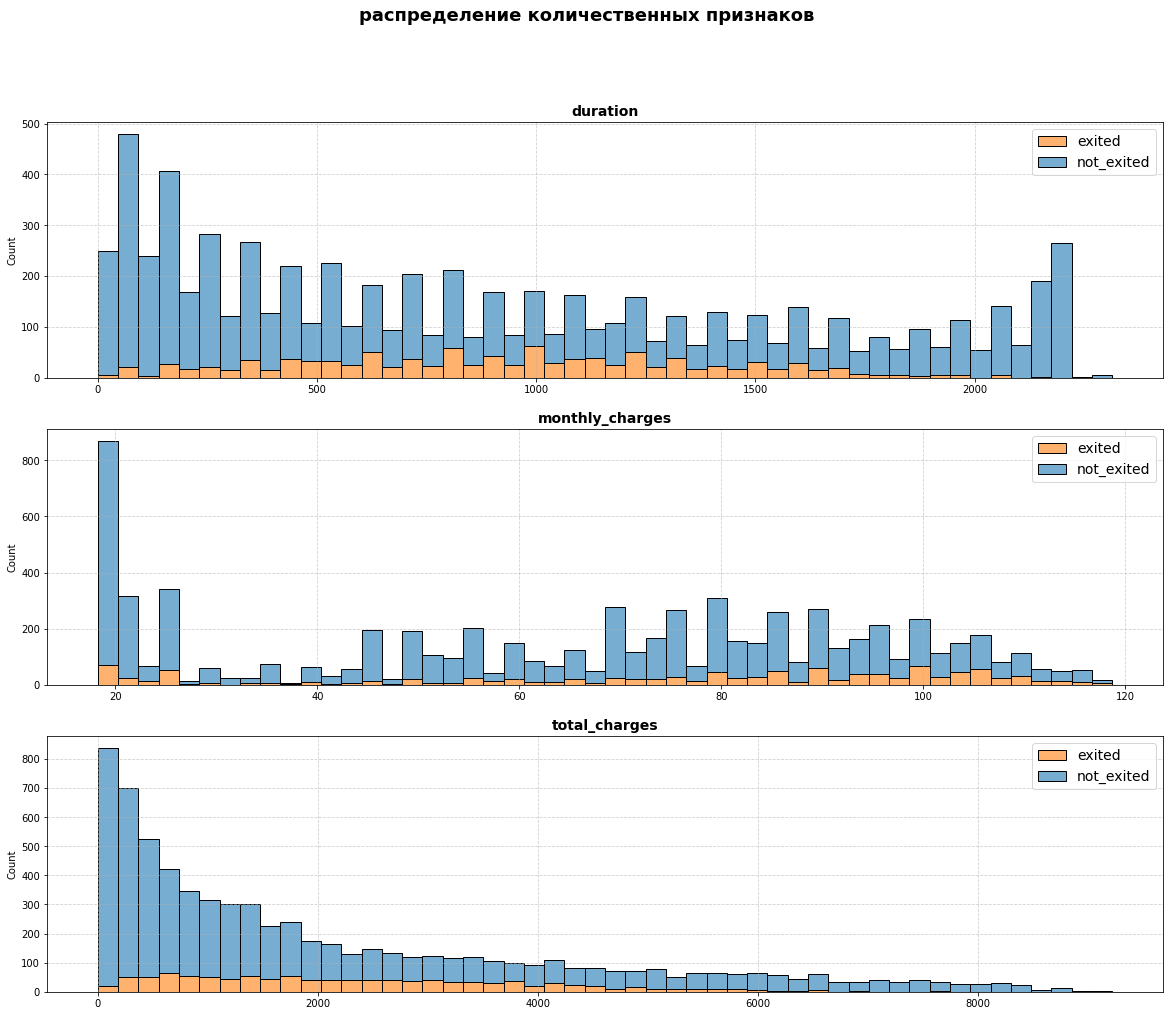

In [34]:
fig, axes = plt.subplots(3, 1, figsize=(20, 16))
fig.suptitle('распределение количественных признаков', fontsize=18, fontweight='bold')

for i, col in enumerate(num):
    axes[i].grid(True, ls='--', alpha=0.6)
    sns.histplot(data = data, x = num[i], hue='exited', bins=50, ax=axes[i], alpha=0.6, multiple="stack")
    axes[i].set_title(col, fontsize=14, fontweight='bold') 
    axes[i].set(xlabel=None)
    axes[i].legend(['exited', 'not_exited'], loc='best', fontsize=14)    

Во всех распределениях количественных признаков присутствуют сильные пики у значения ноль для оставшихся клиентов.
Столбец 'duration' - в основном клиенты, которые ушли, пользовались услугами около 3,3 года. Среди оставшихся много клиентов, которые заключили договор чуть более месяца назад. Также есть пик клиентов, которые пользуются услугами более 5 лет.
Столбец 'monthly_charges' - распределение оставшихся и ушедших клиентов практически одинаковое. Ежемесячный платеж у большинства клиентов составляет 20 ед. - скорее всего это плата за заключение договора, средние платежи от 45 до 100 ед.
Столбец 'total_charges' - у оставшихся клиентов общие расходы в основном не более 100 ед., у ушедших - общие расходы были от 100 ед.

In [35]:
data[num].describe().round(2)

,duration,monthly_charges,total_charges
count,7043.00,7043.00,7043.00
mean,898.56,64.76,2115.31
std,683.13,30.09,2112.74
min,0.00,18.25,0.00
25%,276.00,35.50,436.75
50%,761.00,70.35,1343.35
75%,1461.00,89.85,3236.69
max,2314.00,118.75,9221.38


Все количественные признаки выглядят корректно.

### Распределение категориальных признаков

Проверим распределение категориальных признаков в зависимости от столбца 'exited'

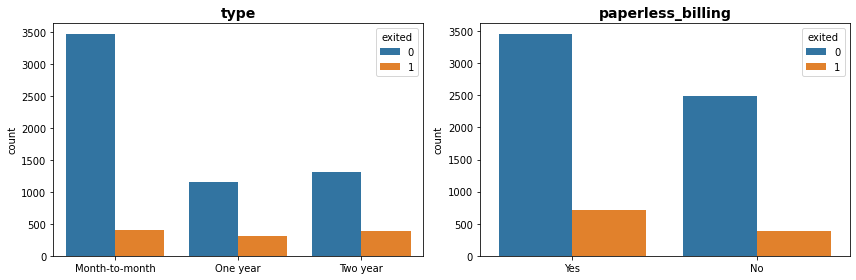

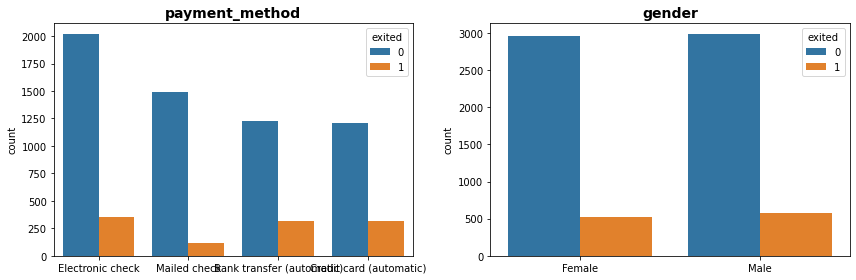

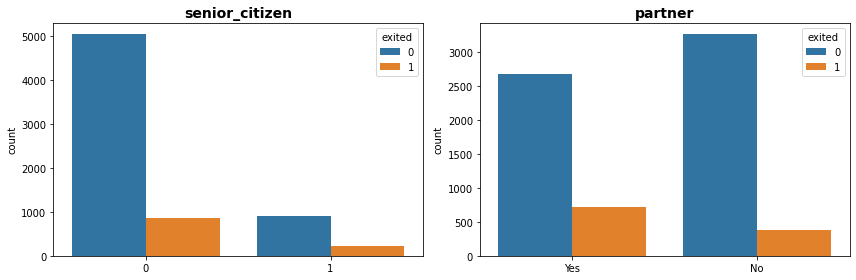

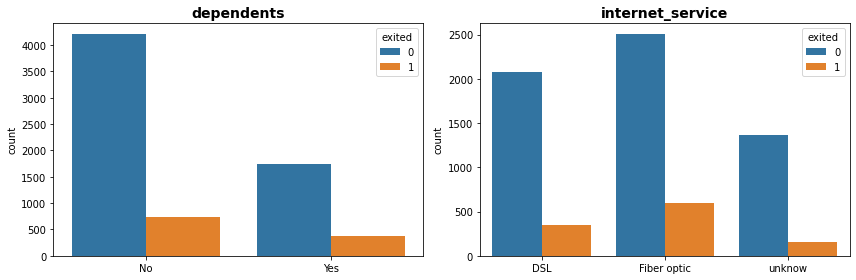

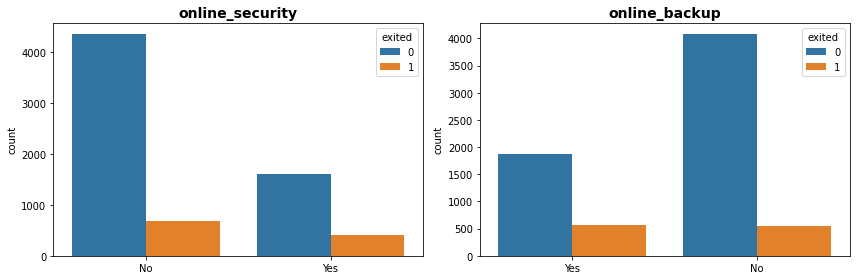

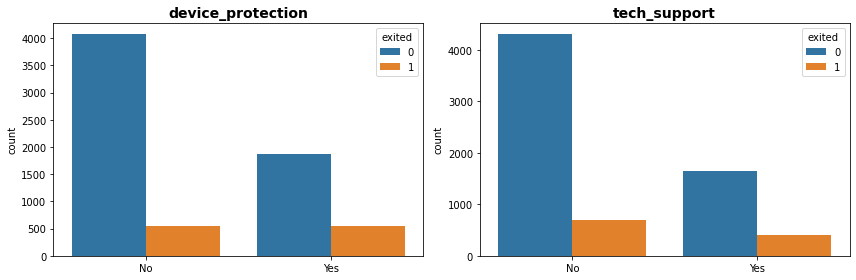

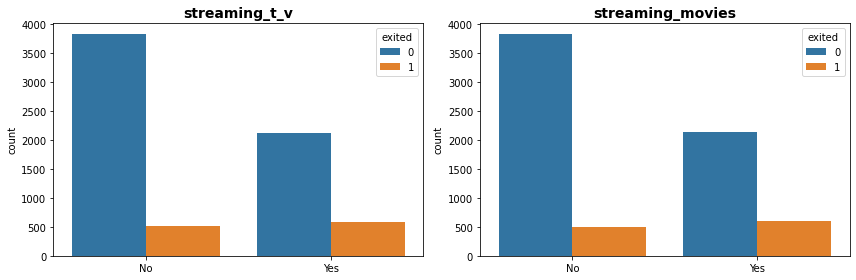

In [36]:
for i in range(0, len(cat)-1, 2):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].set_title(cat[i], fontsize=14, fontweight='bold')
    ax[1].set_title(cat[i+1], fontsize=14, fontweight='bold')

    sns.countplot(data = data, x = data[cat[i]], hue='exited', ax=ax[0])
    sns.countplot(data = data, x = data[cat[i+1]], hue='exited', ax=ax[1])
    
    ax[0].set_xlabel('')
    ax[1].set_xlabel('')
    
    fig.tight_layout()
     
    plt.show();

Тип оплаты у действующих пользователей преобладает Month-to-month. Независимо ушел или остался клиент больше пользуются безналичным расчетом с электронным чеком, используют тип подключения fiber optic, не имеют еждевенцев, не являются пенсионерами. Среди действующих клиентов преобладают одинокие люди, которые в основном не подключают дополнительные услуги стриминга и онлайн-поддержки.

### Матрица корреляций

Исследуем корреляцию признаков, применим инструмент фи-корреляции для смешанного набора признаков.

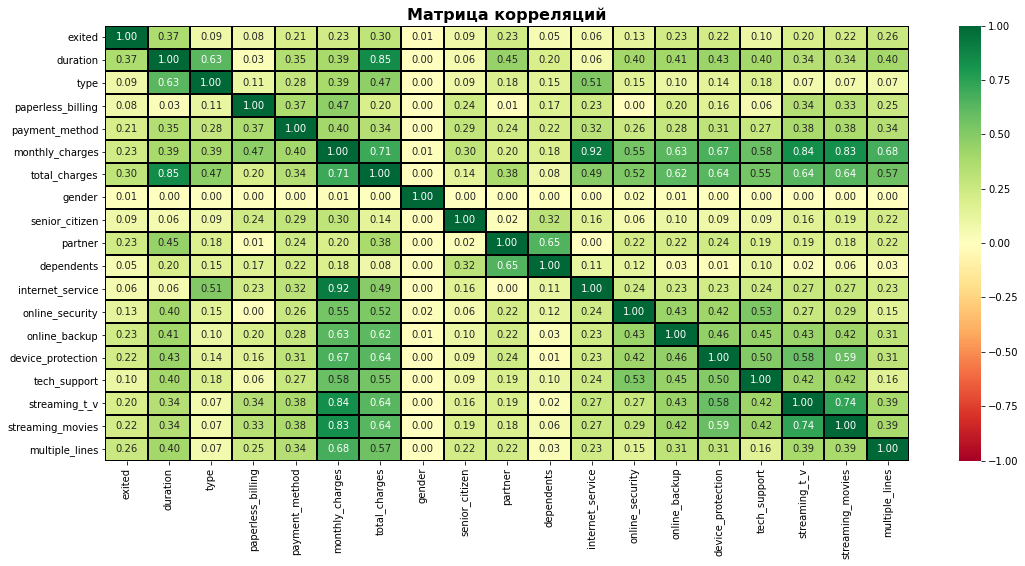

In [37]:
phiK_matmatrix = data.phik_matrix(interval_cols=num).round(2)
plt.figure(figsize=(18,8))
sns.heatmap(phiK_matmatrix, annot=True,
            fmt='.2f', linecolor='black', 
            linewidths=1, cmap='RdYlGn', 
            vmin=-1, vmax=+1)
plt.title('Матрица корреляций', fontsize=16, fontweight='bold')
plt.show()

Столбцы 'internet_service', 'streaming_t_v', 'streaming_movies' сильно коррелируют с признаком 'monthly_charges', их надо удалить.
Cтолбец 'total_charges' сильно коррелирует со столбцом 'duration'.

In [38]:
# Удалим столбцы
delete1=['total_charges', 'internet_service', 'streaming_t_v', 'streaming_movies']
data=data.drop(delete1, axis=1)

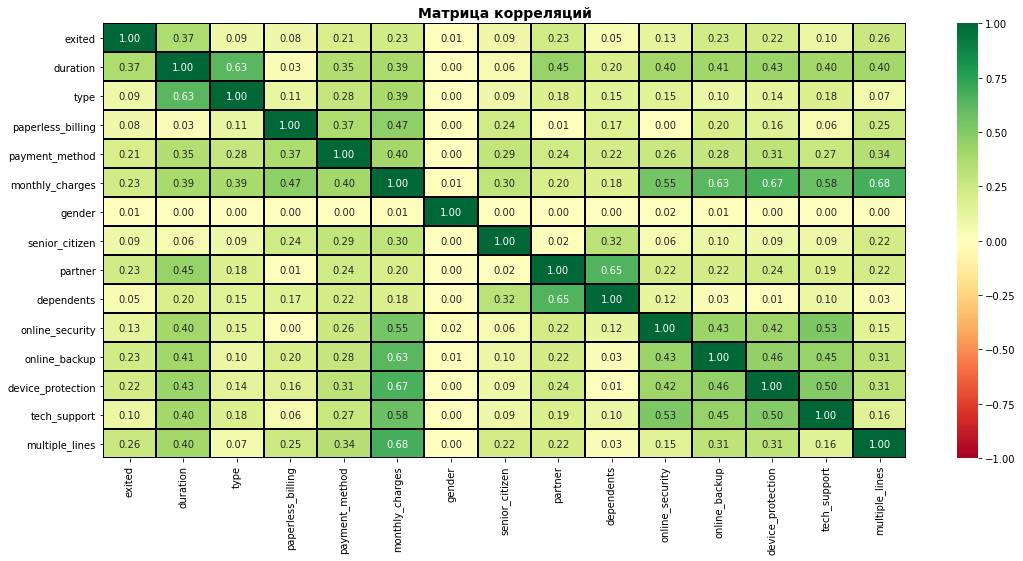

In [39]:
# Проверим изменения
phiK_matmatrix = data.phik_matrix(interval_cols=num).round(2)
plt.figure(figsize=(18,8))
sns.heatmap(phiK_matmatrix, annot=True,
            fmt='.2f',
            linecolor='black', linewidths=1,
            cmap='RdYlGn', vmin=-1, vmax=+1)
plt.title('Матрица корреляций', fontsize=14, fontweight='bold')
plt.show()

Проверим целевой признак на дисбаланс классов

In [40]:
# Получим количество каждого значения для столбца 'exited' в %
(data['exited'].value_counts(normalize=True)*100).round(2)

0    84.37
1    15.63
Name: exited, dtype: float64

Присутствует дисбаланс классов, будем использовать балансировку классов внутри каждой модели. Применим метрику качества AUC-ROC, которая нечувствительна к дисбалансу.

В ходе исследовательского анализа данных мы разделили признаки на количественные и категориальные.  
Построили графики распределения количественных признаков в зависимости от столбца 'exited'. Во всех распределениях количественных признаков присутствуют сильные пики у значения ноль для оставшихся клиентов. Столбец 'duration' - в основном клиенты, которые ушли, пользовались услугами около 3,3 года. Среди оставшихся много клиентов, которые заключили договор чуть более месяца назад. Также есть пик клиентов, которые пользуются услугами более 5 лет. Столбец 'monthly_charges' - распределение оставшихся и ушедших клиентов практически одинаковое. Ежемесячный платеж у большинства клиентов составляет 20 ед. - скорее всего это плата за заключение договора, средние платежи от 45 до 100 ед. Столбец 'total_charges' - у оставшихся клиентов общие расходы в основном не более 100 ед., у ушедших - общие расходы были от 100 ед.  
Построили графики распределения категориальных признаков в зависимости от столбца 'exited'.  
Тип оплаты у действующих пользователей преобладает Month-to-month. Независимо ушел или остался клиент больше пользуются безналичным расчетом с электронным чеком, используют тип подключения fiber optic, не имеют еждевенцев, не являются пенсионерами. Среди действующих клиентов преобладают одинокие люди, которые в основном не подключают дополнительные услуги стриминга и онлайн-поддержки.  
Исследовали корреляцию признаков, применив инструмент фи-корреляции для смешанного набора признаков. Выявили, что столбцы 'internet_service', 'streaming_t_v', 'streaming_movies' сильно коррелируют с признаком 'monthly_charges'. Cтолбец 'total_charges' сильно коррелирует со столбцом 'duration'. Удалили столбцы 'internet_service', 'streaming_t_v', 'streaming_movies' и 'total_charges'.  
Проверим целевой признак на дисбаланс классов. Выявили, что присутствует дисбаланс классов, будем использовать балансировку классов внутри каждой модели. Применим метрику качества AUC-ROC, которая нечувствительна к дисбалансу.

## Подготовка признаков для обучения моделей

In [41]:
# Разобьем данные data на признаки и целевой признак, сохраним в отдельных переменных
features = data.drop('exited', axis=1)
target = data.exited

In [42]:
# Разобьем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE) 

In [43]:
# Выведем на экран размеры этих выборок
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5282, 14)
(5282,)
(1761, 14)
(1761,)


In [44]:
# Категориальные признаки для OHE кодирония 
cat_features = X_train.select_dtypes(include='object').columns.to_list()
cat_features

['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'multiple_lines']

In [45]:
# Численные признаки
num_features = X_train.select_dtypes(exclude='object').columns.to_list()
num_features

['duration', 'monthly_charges']

На этапе подготовки признаков для дальнейшего обучения моделей мы разделили данные data на признаки и целевой признак и сохранили в отдельных переменных. Разобили данные на тренировочную и тестовую выборки. Проверили размеры выборок. Подготовили категориальные признаки для OHE кодирования и количественные признаки для масштабирования.

## Обучение моделей

Для обучения моделей применим следующие библиотеки: LogisticRegression, RandomForestClassifier, LightGBMClassifier и CatBoostClassifier.

###  LogisticRegression

In [46]:
# Масштабируем признаки
preprocessor = ColumnTransformer(transformers=[
                                 ('numerical', StandardScaler(), num_features),
                                 ('categorical_ohe', OneHotEncoder(), cat_features)])

In [47]:
%%time

model_lr = LogisticRegression(class_weight='balanced',
                              random_state=RANDOM_STATE)

# Создадим пайплайн
pipeline_lr = Pipeline([('preprocessor', preprocessor),
                       ('logisticregression', model_lr)])

# Cловарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_lr = {'logisticregression__solver':['lbfgs', 'liblinear'],
                 'logisticregression__class_weight': [None, 'balanced']}

# Будем использовать RandomizedSearchCV при переборе комбинаций гиперпараметров
random_cv_lr = RandomizedSearchCV(estimator=pipeline_lr, 
                           param_distributions=param_grid_lr, 
                           scoring='roc_auc',
                           cv=10,
                           n_iter=50,
                           n_jobs=-1, 
                           random_state=RANDOM_STATE,
                           verbose=10)

random_cv_lr.fit(X_train, y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV 1/10; 1/4] START logisticregression__class_weight=None, logisticregression__solver=lbfgs
[CV 1/10; 1/4] END logisticregression__class_weight=None, logisticregression__solver=lbfgs; total time=   0.5s
[CV 2/10; 1/4] START logisticregression__class_weight=None, logisticregression__solver=lbfgs
[CV 2/10; 1/4] END logisticregression__class_weight=None, logisticregression__solver=lbfgs; total time=   1.1s
[CV 3/10; 1/4] START logisticregression__class_weight=None, logisticregression__solver=lbfgs
[CV 3/10; 1/4] END logisticregression__class_weight=None, logisticregression__solver=lbfgs; total time=   0.8s
[CV 4/10; 1/4] START logisticregression__class_weight=None, logisticregression__solver=lbfgs
[CV 4/10; 1/4] END logisticregression__class_weight=None, logisticregression__solver=lbfgs; total time=   1.3s
[CV 5/10; 1/4] START logisticregression__class_weight=None, logisticregression__solver=lbfgs
[CV 5/10; 1/4] END logisticreg

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('numerical',
                                                                               StandardScaler(),
                                                                               ['duration',
                                                                                'monthly_charges']),
                                                                              ('categorical_ohe',
                                                                               OneHotEncoder(),
                                                                               ['type',
                                                                                'paperless_billing',
                                                                                'payment_method',
                                                 

In [48]:
random_cv_lr_best_score = random_cv_lr.best_score_.round(2) 
random_cv_lr_best_params = random_cv_lr.best_params_

# Лучшее значение метрики AUC-ROC 
print(f'best_score: {random_cv_lr_best_score}')
# Лучшие гиперпараметры
print(f'best_params: {random_cv_lr_best_params}')

best_score: 0.75
best_params: {'logisticregression__solver': 'liblinear', 'logisticregression__class_weight': 'balanced'}


### RandomForestClassifier

In [49]:
%%time

model_rf = RandomForestClassifier(class_weight='balanced',
                                  random_state=RANDOM_STATE)

# Создадим пайплайн
pipeline_rf = Pipeline([('preprocessor', preprocessor),
                       ('randomforestclassifier', model_rf)])

# Cловарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_rf = {'randomforestclassifier__n_estimators': range(2, 51, 2),
                 'randomforestclassifier__max_depth': range(2, 15),
                 'randomforestclassifier__min_samples_split': (2, 3, 4),
                 'randomforestclassifier__min_samples_leaf': (1, 2, 3, 4)}

# Будем использовать RandomizedSearchCV при переборе комбинаций гиперпараметров
random_cv_rf = RandomizedSearchCV(estimator=pipeline_rf, 
                           param_distributions=param_grid_rf, 
                           scoring='roc_auc',
                           cv=5,
                           n_iter=10,
                           n_jobs=-1, 
                           random_state=RANDOM_STATE,
                           verbose=10)

random_cv_rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START randomforestclassifier__max_depth=6, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=42
[CV 1/5; 1/10] END randomforestclassifier__max_depth=6, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=42; total time=   0.2s
[CV 2/5; 1/10] START randomforestclassifier__max_depth=6, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=42
[CV 2/5; 1/10] END randomforestclassifier__max_depth=6, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=42; total time=   0.1s
[CV 3/5; 1/10] START randomforestclassifier__max_depth=6, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=3, randomfo

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('numerical',
                                                                               StandardScaler(),
                                                                               ['duration',
                                                                                'monthly_charges']),
                                                                              ('categorical_ohe',
                                                                               OneHotEncoder(),
                                                                               ['type',
                                                                                'paperless_billing',
                                                                                'payment_method',
                                                  

In [50]:
random_cv_rf_best_score = random_cv_rf.best_score_.round(2) 
random_cv_rf_best_params = random_cv_rf.best_params_

# Лучшее значение метрики AUC-ROC 
print(f'best_score: {random_cv_rf_best_score}')
# Лучшие гиперпараметры
print(f'best_params: {random_cv_rf_best_params}')

best_score: 0.81
best_params: {'randomforestclassifier__n_estimators': 42, 'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__max_depth': 6}


### LGBMClassifier

In [67]:
%%time

model_lgbm = LGBMClassifier(boosting_type='gbdt',
                           class_weight='balanced',
                           random_state=RANDOM_STATE)
# Создадим пайплайн                        
pipeline_lgbm = Pipeline([('preprocessor', preprocessor),
                          ('lightgbmclassifier', model_lgbm)])

# Cловарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_lgbm = {'lightgbmclassifier__n_estimators': range(2, 51, 2),
                   'lightgbmclassifier__max_depth': range(2, 8),
                   'lightgbmclassifier__num_leaves': [50, 100, 200],
                   'lightgbmclassifier__learning_rate': [.1, .3, .5]}

# Будем использовать RandomizedSearchCV при переборе комбинаций гиперпараметров
random_cv_lgbm = RandomizedSearchCV(estimator=pipeline_lgbm, 
                                    param_distributions=param_grid_lgbm, 
                                    scoring='roc_auc',
                                    cv=5,
                                    n_iter=10,
                                    n_jobs=-1, 
                                    random_state=RANDOM_STATE,
                                    verbose=10)

random_cv_lgbm.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START lightgbmclassifier__learning_rate=0.5, lightgbmclassifier__max_depth=7, lightgbmclassifier__n_estimators=18, lightgbmclassifier__num_leaves=100
[CV 1/5; 1/10] END lightgbmclassifier__learning_rate=0.5, lightgbmclassifier__max_depth=7, lightgbmclassifier__n_estimators=18, lightgbmclassifier__num_leaves=100; total time=  14.4s
[CV 2/5; 1/10] START lightgbmclassifier__learning_rate=0.5, lightgbmclassifier__max_depth=7, lightgbmclassifier__n_estimators=18, lightgbmclassifier__num_leaves=100
[CV 2/5; 1/10] END lightgbmclassifier__learning_rate=0.5, lightgbmclassifier__max_depth=7, lightgbmclassifier__n_estimators=18, lightgbmclassifier__num_leaves=100; total time=   9.1s
[CV 3/5; 1/10] START lightgbmclassifier__learning_rate=0.5, lightgbmclassifier__max_depth=7, lightgbmclassifier__n_estimators=18, lightgbmclassifier__num_leaves=100
[CV 3/5; 1/10] END lightgbmclassifier__learning_rate=0.5, lightgbmclassifier__

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('numerical',
                                                                               StandardScaler(),
                                                                               ['duration',
                                                                                'monthly_charges']),
                                                                              ('categorical_ohe',
                                                                               OneHotEncoder(),
                                                                               ['type',
                                                                                'paperless_billing',
                                                                                'payment_method',
                                                  

In [68]:
random_cv_lgbm_best_score = random_cv_lgbm.best_score_.round(2)
random_cv_lgbm_best_params = random_cv_lgbm.best_params_

# лучшее значение метрики AUC-ROC 
print(f'best_score: {random_cv_lgbm_best_score}')
# лучшие гиперпараметры
print(f'best_params: {random_cv_lgbm_best_params}')

best_score: 0.86
best_params: {'lightgbmclassifier__num_leaves': 200, 'lightgbmclassifier__n_estimators': 46, 'lightgbmclassifier__max_depth': 5, 'lightgbmclassifier__learning_rate': 0.3}


### CatBoostClassifier

[I 2023-08-24 14:06:10,521] A new study created in memory with name: no-name-27cea7ae-86fe-4a9a-991a-5d8dba39f0f6



Training on split 1/5
0:	learn: 0.6265146	test: 0.6405501	best: 0.6405501 (0)	total: 63.3ms	remaining: 24.3s
100:	learn: 0.2511892	test: 0.4790986	best: 0.4786710 (98)	total: 539ms	remaining: 1.51s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4540429054
bestIteration = 141

Shrink model to first 142 iterations.
Split 1, ROC-AUC : 0.8867086052613873

Training on split 2/5
0:	learn: 0.6316515	test: 0.6375131	best: 0.6375131 (0)	total: 6.01ms	remaining: 2.3s
100:	learn: 0.2500960	test: 0.4926932	best: 0.4926932 (100)	total: 478ms	remaining: 1.34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4792107432
bestIteration = 140

Shrink model to first 141 iterations.
Split 2, ROC-AUC : 0.8761555540604186

Training on split 3/5
0:	learn: 0.6305568	test: 0.6386862	best: 0.6386862 (0)	total: 6.42ms	remaining: 2.46s
100:	learn: 0.2674960	test: 0.4636756	best: 0.4636173 (99)	total: 492ms	remaining: 1.38s
Stopped by overfitting detector  (50 iterations wai

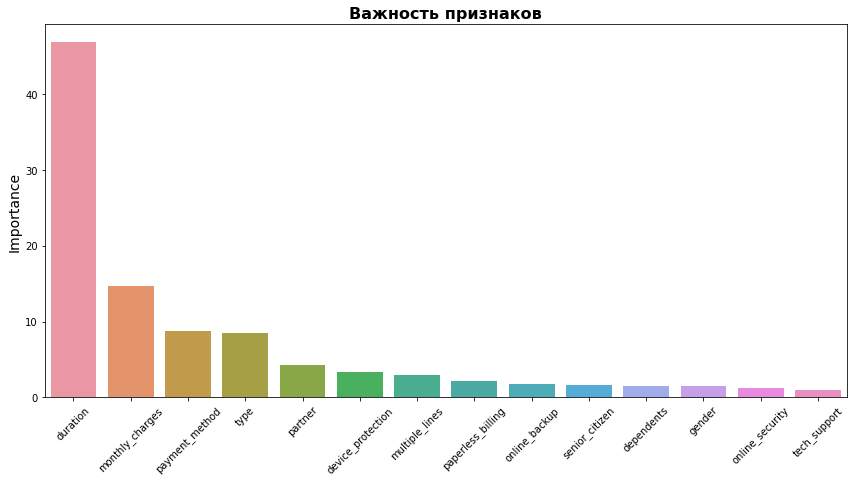

[I 2023-08-24 14:06:23,240] Trial 0 finished with value: 0.8968776917533553 and parameters: {'algorithm': 'CatBoost', 'depth': 6, 'iterations': 384, 'learning_rate': 0.22, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8968776917533553.



Training on split 1/5
0:	learn: 0.6663569	test: 0.6714784	best: 0.6714784 (0)	total: 5.7ms	remaining: 2.54s
100:	learn: 0.4047410	test: 0.5514784	best: 0.5502754 (95)	total: 501ms	remaining: 1.72s
200:	learn: 0.2801449	test: 0.5082438	best: 0.5082438 (200)	total: 1.1s	remaining: 1.35s
300:	learn: 0.2131328	test: 0.4908411	best: 0.4868842 (284)	total: 1.74s	remaining: 844ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4849117227
bestIteration = 317

Shrink model to first 318 iterations.
Split 1, ROC-AUC : 0.8694577137859113

Training on split 2/5
0:	learn: 0.6685930	test: 0.6707988	best: 0.6707988 (0)	total: 8.04ms	remaining: 3.59s
100:	learn: 0.3961119	test: 0.5204422	best: 0.5196356 (90)	total: 532ms	remaining: 1.82s
200:	learn: 0.2750313	test: 0.5038407	best: 0.5037525 (199)	total: 1.13s	remaining: 1.38s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4923812372
bestIteration = 244

Shrink model to first 245 iterations.
Split 2, ROC-AUC : 0

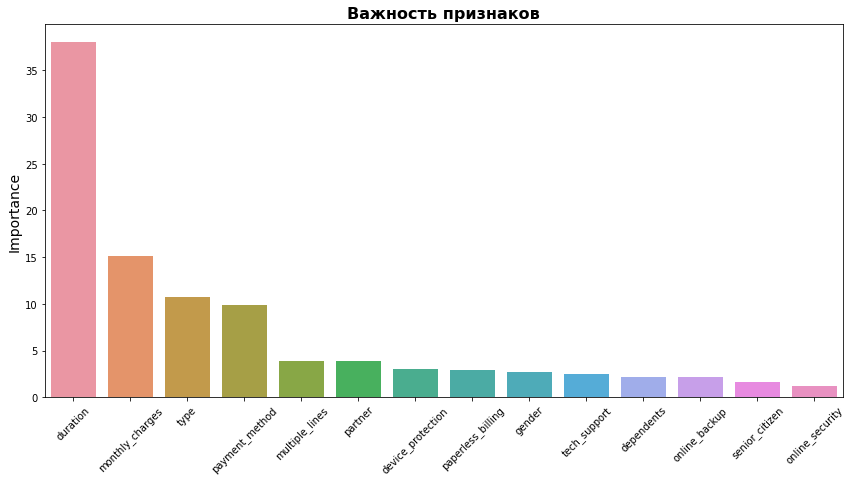

[I 2023-08-24 14:06:41,531] Trial 1 finished with value: 0.8832661278228706 and parameters: {'algorithm': 'CatBoost', 'depth': 7, 'iterations': 447, 'learning_rate': 0.08, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8968776917533553.



Training on split 1/5
0:	learn: 0.6664821	test: 0.6722967	best: 0.6722967 (0)	total: 3.13ms	remaining: 1.59s
100:	learn: 0.4544608	test: 0.5294565	best: 0.5294565 (100)	total: 277ms	remaining: 1.12s
200:	learn: 0.3948095	test: 0.4969050	best: 0.4969050 (200)	total: 550ms	remaining: 845ms
300:	learn: 0.3533575	test: 0.4807250	best: 0.4806770 (299)	total: 831ms	remaining: 577ms
400:	learn: 0.3154495	test: 0.4654946	best: 0.4654854 (399)	total: 1.13s	remaining: 308ms
500:	learn: 0.2828472	test: 0.4466353	best: 0.4459934 (497)	total: 1.43s	remaining: 25.6ms
509:	learn: 0.2795493	test: 0.4441741	best: 0.4441741 (509)	total: 1.45s	remaining: 0us

bestTest = 0.4441740827
bestIteration = 509

Split 1, ROC-AUC : 0.8831225190069298

Training on split 2/5
0:	learn: 0.6689894	test: 0.6695969	best: 0.6695969 (0)	total: 3.04ms	remaining: 1.54s
100:	learn: 0.4552498	test: 0.5118941	best: 0.5102256 (96)	total: 268ms	remaining: 1.08s
200:	learn: 0.3780079	test: 0.4884225	best: 0.4884225 (200)	total: 5

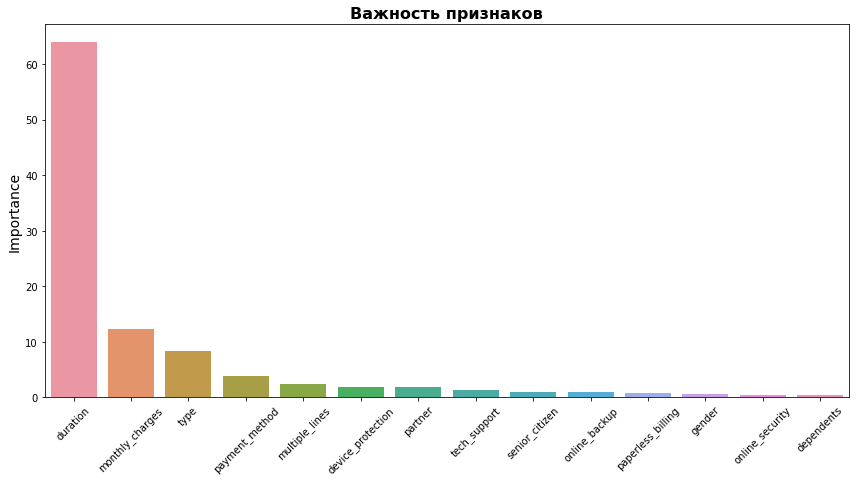

[I 2023-08-24 14:06:54,914] Trial 2 finished with value: 0.9043973512295835 and parameters: {'algorithm': 'CatBoost', 'depth': 3, 'iterations': 510, 'learning_rate': 0.12, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.9043973512295835.



Training on split 1/5
0:	learn: 0.6540678	test: 0.6617429	best: 0.6617429 (0)	total: 4.6ms	remaining: 3.66s
100:	learn: 0.3965417	test: 0.5185285	best: 0.5185285 (100)	total: 372ms	remaining: 2.56s
200:	learn: 0.2959398	test: 0.4764346	best: 0.4764346 (200)	total: 851ms	remaining: 2.52s
300:	learn: 0.2329873	test: 0.4642245	best: 0.4597722 (280)	total: 1.28s	remaining: 2.1s
400:	learn: 0.1891708	test: 0.4456973	best: 0.4443156 (396)	total: 1.68s	remaining: 1.66s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4443155969
bestIteration = 396

Shrink model to first 397 iterations.
Split 1, ROC-AUC : 0.8906378254726504

Training on split 2/5
0:	learn: 0.6572603	test: 0.6605371	best: 0.6605371 (0)	total: 4.88ms	remaining: 3.88s
100:	learn: 0.3963278	test: 0.5064299	best: 0.5056614 (96)	total: 368ms	remaining: 2.53s
200:	learn: 0.2820760	test: 0.4802820	best: 0.4800147 (185)	total: 773ms	remaining: 2.29s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0

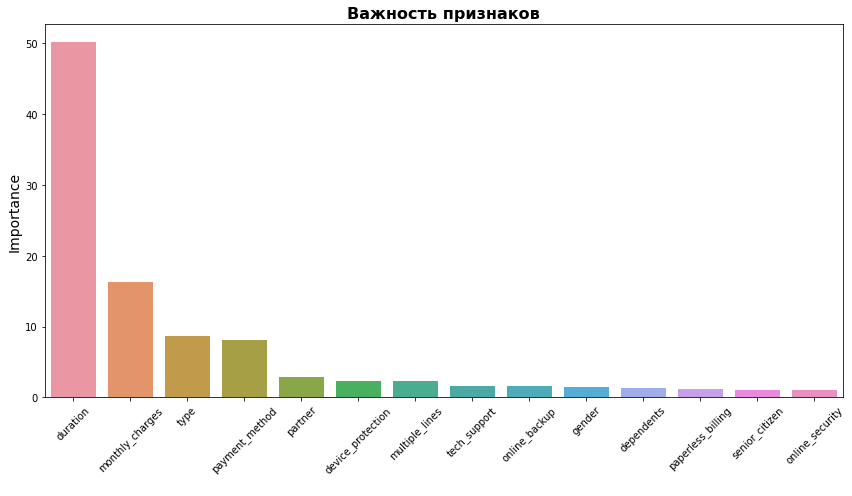

[I 2023-08-24 14:07:11,033] Trial 3 finished with value: 0.9019346821451182 and parameters: {'algorithm': 'CatBoost', 'depth': 5, 'iterations': 796, 'learning_rate': 0.12, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.9043973512295835.



Training on split 1/5
0:	learn: 0.6309425	test: 0.6461928	best: 0.6461928 (0)	total: 3.25ms	remaining: 2.06s
100:	learn: 0.3438832	test: 0.4728603	best: 0.4719621 (97)	total: 300ms	remaining: 1.58s
200:	learn: 0.2567122	test: 0.4355022	best: 0.4318912 (198)	total: 586ms	remaining: 1.26s
300:	learn: 0.2040169	test: 0.4187546	best: 0.4164322 (287)	total: 881ms	remaining: 977ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4164321763
bestIteration = 287

Shrink model to first 288 iterations.
Split 1, ROC-AUC : 0.9035490816120569

Training on split 2/5
0:	learn: 0.6365784	test: 0.6377934	best: 0.6377934 (0)	total: 3.11ms	remaining: 1.97s
100:	learn: 0.3244624	test: 0.4533593	best: 0.4533593 (100)	total: 339ms	remaining: 1.79s
200:	learn: 0.2449964	test: 0.4442638	best: 0.4398719 (187)	total: 638ms	remaining: 1.38s
300:	learn: 0.1966858	test: 0.4305620	best: 0.4305620 (300)	total: 931ms	remaining: 1.03s
Stopped by overfitting detector  (50 iterations wait)

bestTest =

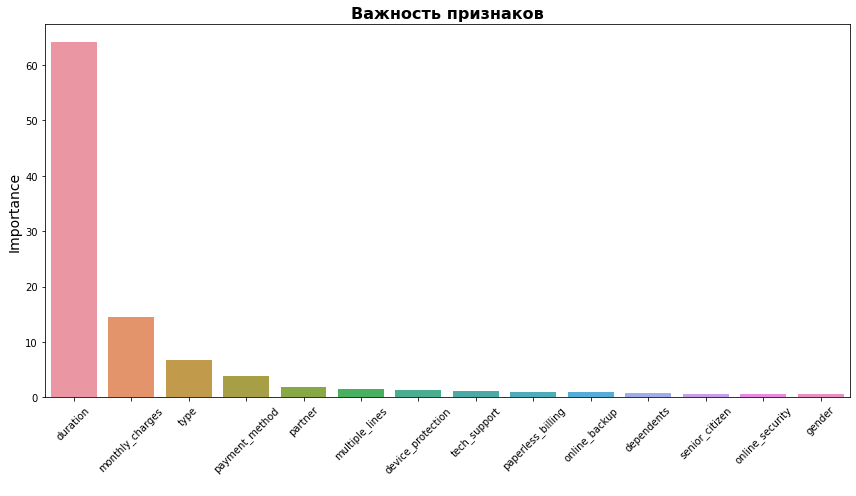

[I 2023-08-24 14:07:22,776] Trial 4 finished with value: 0.9174890505978702 and parameters: {'algorithm': 'CatBoost', 'depth': 3, 'iterations': 635, 'learning_rate': 0.32, 'auto_class_weights': 'Balanced'}. Best is trial 4 with value: 0.9174890505978702.



Training on split 1/5
0:	learn: 0.6744474	test: 0.6784502	best: 0.6784502 (0)	total: 5.65ms	remaining: 3s
100:	learn: 0.4788579	test: 0.5449998	best: 0.5448493 (99)	total: 332ms	remaining: 1.42s
200:	learn: 0.4287154	test: 0.5249599	best: 0.5242217 (199)	total: 692ms	remaining: 1.14s
300:	learn: 0.3736130	test: 0.4881538	best: 0.4878698 (297)	total: 1.05s	remaining: 810ms
400:	learn: 0.3427185	test: 0.4728144	best: 0.4725211 (395)	total: 1.46s	remaining: 482ms
500:	learn: 0.3130811	test: 0.4568622	best: 0.4557028 (489)	total: 1.8s	remaining: 115ms
532:	learn: 0.3056475	test: 0.4544220	best: 0.4544220 (532)	total: 1.91s	remaining: 0us

bestTest = 0.4544219966
bestIteration = 532

Split 1, ROC-AUC : 0.8753616362780058

Training on split 2/5
0:	learn: 0.6762029	test: 0.6772294	best: 0.6772294 (0)	total: 4.17ms	remaining: 2.21s
100:	learn: 0.4833459	test: 0.5188052	best: 0.5188052 (100)	total: 314ms	remaining: 1.34s
200:	learn: 0.4270673	test: 0.5063343	best: 0.5060994 (197)	total: 652ms	

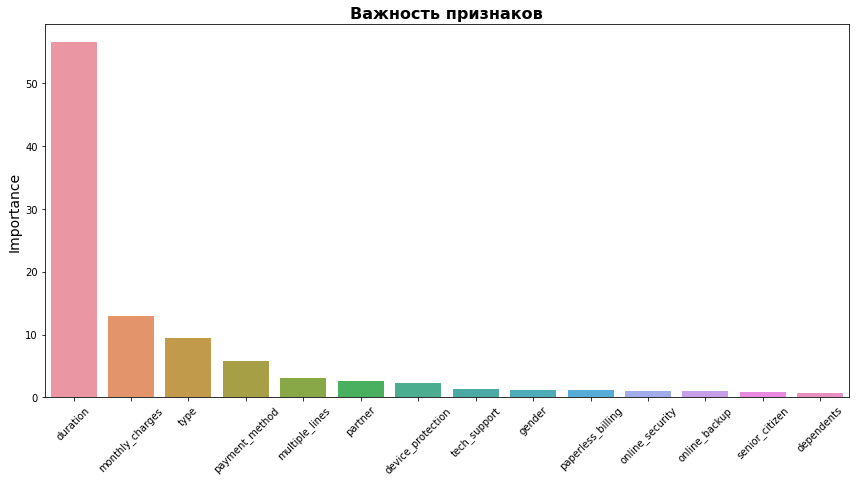

[I 2023-08-24 14:07:39,278] Trial 5 finished with value: 0.8893856418745019 and parameters: {'algorithm': 'CatBoost', 'depth': 4, 'iterations': 533, 'learning_rate': 0.060000000000000005, 'auto_class_weights': 'Balanced'}. Best is trial 4 with value: 0.9174890505978702.



Training on split 1/5
0:	learn: 0.6197445	test: 0.6386828	best: 0.6386828 (0)	total: 4.03ms	remaining: 3.02s
100:	learn: 0.3211883	test: 0.4622577	best: 0.4622552 (99)	total: 343ms	remaining: 2.21s
200:	learn: 0.2245170	test: 0.4205346	best: 0.4205346 (200)	total: 672ms	remaining: 1.84s
300:	learn: 0.1793051	test: 0.4104450	best: 0.4082616 (292)	total: 1000ms	remaining: 1.49s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4082616337
bestIteration = 292

Shrink model to first 293 iterations.
Split 1, ROC-AUC : 0.9112124066473795

Training on split 2/5
0:	learn: 0.6262912	test: 0.6276127	best: 0.6276127 (0)	total: 3.47ms	remaining: 2.6s
100:	learn: 0.3050324	test: 0.4729294	best: 0.4605414 (90)	total: 318ms	remaining: 2.04s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4605413639
bestIteration = 90

Shrink model to first 91 iterations.
Split 2, ROC-AUC : 0.8722364260243557

Training on split 3/5
0:	learn: 0.6288668	test: 0.6323023	best: 0.63230

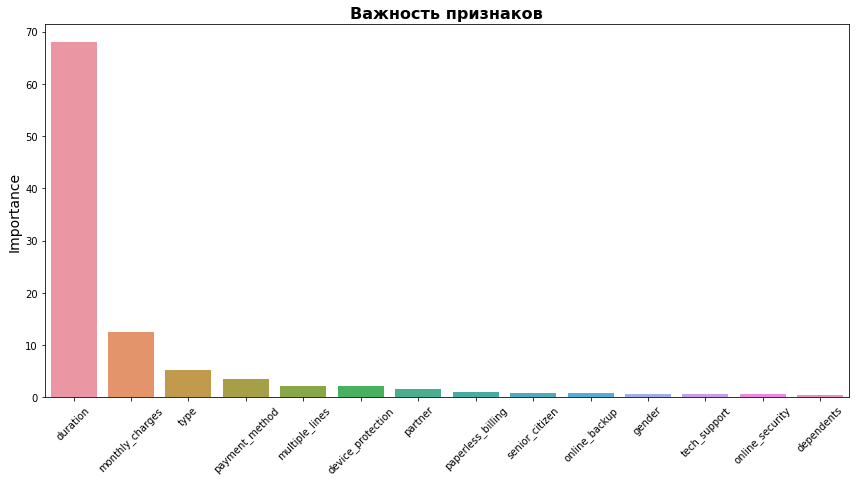

[I 2023-08-24 14:07:48,288] Trial 6 finished with value: 0.9112870320007069 and parameters: {'algorithm': 'CatBoost', 'depth': 3, 'iterations': 751, 'learning_rate': 0.4, 'auto_class_weights': 'Balanced'}. Best is trial 4 with value: 0.9174890505978702.



Training on split 1/5
0:	learn: 0.5718762	test: 0.6034617	best: 0.6034617 (0)	total: 5.87ms	remaining: 4.15s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5556619059
bestIteration = 6

Shrink model to first 7 iterations.
Split 1, ROC-AUC : 0.7931675973894907

Training on split 2/5
0:	learn: 0.5797069	test: 0.5921189	best: 0.5921189 (0)	total: 5.95ms	remaining: 4.21s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5420790016
bestIteration = 4

Shrink model to first 5 iterations.
Split 2, ROC-AUC : 0.7940758931575052

Training on split 3/5
0:	learn: 0.5546268	test: 0.5936887	best: 0.5936887 (0)	total: 9.2ms	remaining: 6.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5518947362
bestIteration = 3

Shrink model to first 4 iterations.
Split 3, ROC-AUC : 0.7973737647218087

Training on split 4/5
0:	learn: 0.5687639	test: 0.5816154	best: 0.5816154 (0)	total: 13ms	remaining: 9.17s
Stopped by overfitting detector  (50 iterations 

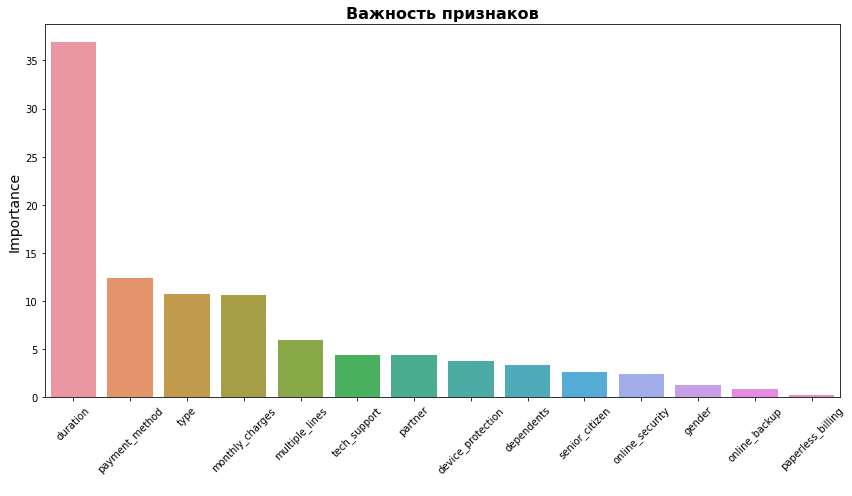

[I 2023-08-24 14:07:54,853] Trial 7 finished with value: 0.8155724289879697 and parameters: {'algorithm': 'CatBoost', 'depth': 8, 'iterations': 708, 'learning_rate': 0.5, 'auto_class_weights': 'Balanced'}. Best is trial 4 with value: 0.9174890505978702.



Training on split 1/5
0:	learn: 0.6265146	test: 0.6405501	best: 0.6405501 (0)	total: 8.04ms	remaining: 5.67s
100:	learn: 0.2511892	test: 0.4790986	best: 0.4786710 (98)	total: 490ms	remaining: 2.94s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4540429054
bestIteration = 141

Shrink model to first 142 iterations.
Split 1, ROC-AUC : 0.8867086052613873

Training on split 2/5
0:	learn: 0.6316515	test: 0.6375131	best: 0.6375131 (0)	total: 5.5ms	remaining: 3.88s
100:	learn: 0.2500960	test: 0.4926932	best: 0.4926932 (100)	total: 501ms	remaining: 3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4792107432
bestIteration = 140

Shrink model to first 141 iterations.
Split 2, ROC-AUC : 0.8761555540604186

Training on split 3/5
0:	learn: 0.6305568	test: 0.6386862	best: 0.6386862 (0)	total: 6.24ms	remaining: 4.41s
100:	learn: 0.2674960	test: 0.4636756	best: 0.4636173 (99)	total: 465ms	remaining: 2.79s
Stopped by overfitting detector  (50 iterations wait)


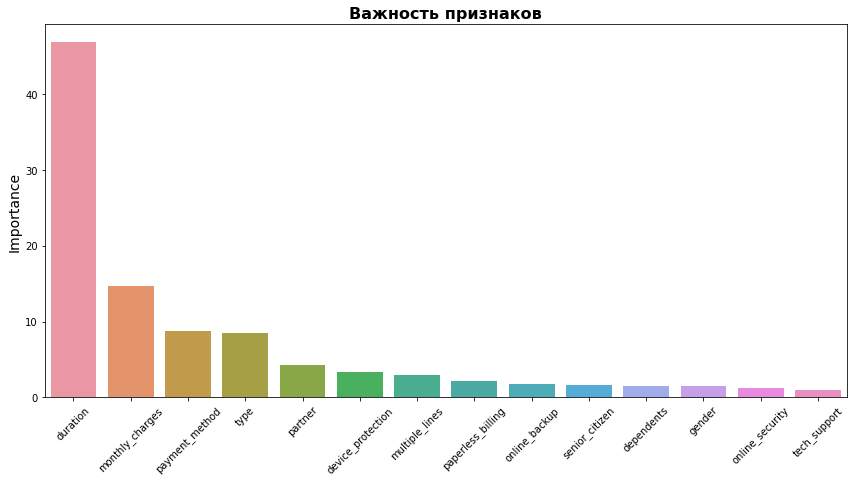

[I 2023-08-24 14:08:04,861] Trial 8 finished with value: 0.8968776917533553 and parameters: {'algorithm': 'CatBoost', 'depth': 6, 'iterations': 707, 'learning_rate': 0.22, 'auto_class_weights': 'Balanced'}. Best is trial 4 with value: 0.9174890505978702.



Training on split 1/5
0:	learn: 0.6793076	test: 0.6822295	best: 0.6822295 (0)	total: 3ms	remaining: 1.58s
100:	learn: 0.4935997	test: 0.5465148	best: 0.5462630 (96)	total: 269ms	remaining: 1.14s
200:	learn: 0.4533796	test: 0.5344852	best: 0.5342008 (191)	total: 548ms	remaining: 889ms
300:	learn: 0.4210878	test: 0.5174732	best: 0.5172708 (297)	total: 891ms	remaining: 669ms
400:	learn: 0.3986743	test: 0.5050126	best: 0.5050126 (400)	total: 1.19s	remaining: 375ms
500:	learn: 0.3700509	test: 0.4931465	best: 0.4925893 (480)	total: 1.49s	remaining: 77.1ms
526:	learn: 0.3636989	test: 0.4909871	best: 0.4906823 (525)	total: 1.58s	remaining: 0us

bestTest = 0.4906822914
bestIteration = 525

Shrink model to first 526 iterations.
Split 1, ROC-AUC : 0.8453710556415258

Training on split 2/5
0:	learn: 0.6806221	test: 0.6809490	best: 0.6809490 (0)	total: 4.92ms	remaining: 2.58s
100:	learn: 0.4958013	test: 0.5230413	best: 0.5230413 (100)	total: 273ms	remaining: 1.15s
200:	learn: 0.4547375	test: 0.510

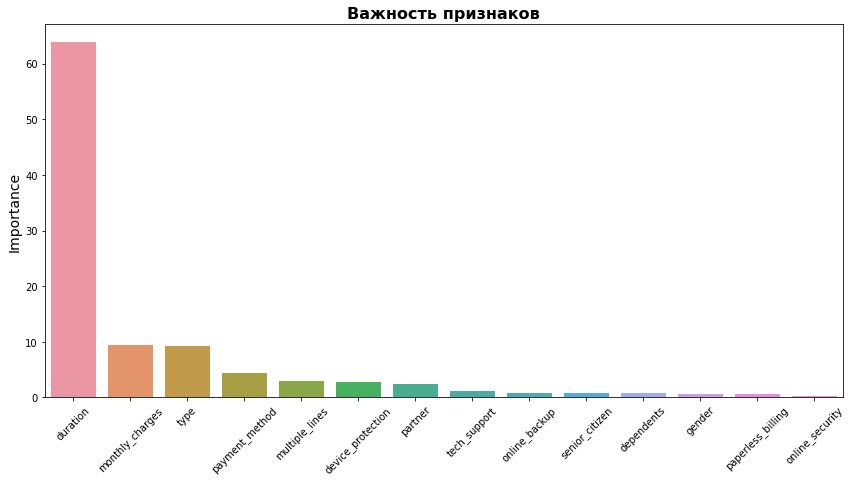

[I 2023-08-24 14:08:18,972] Trial 9 finished with value: 0.8721041009898437 and parameters: {'algorithm': 'CatBoost', 'depth': 3, 'iterations': 527, 'learning_rate': 0.060000000000000005, 'auto_class_weights': 'Balanced'}. Best is trial 4 with value: 0.9174890505978702.



Training on split 1/5
0:	learn: 0.5992159	test: 0.6208278	best: 0.6208278 (0)	total: 7.78ms	remaining: 4.7s
100:	learn: 0.2450906	test: 0.4951216	best: 0.4899461 (89)	total: 437ms	remaining: 2.18s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4772009668
bestIteration = 139

Shrink model to first 140 iterations.
Split 1, ROC-AUC : 0.87687882661643

Training on split 2/5
0:	learn: 0.6059334	test: 0.6147239	best: 0.6147239 (0)	total: 4.44ms	remaining: 2.68s
100:	learn: 0.2287033	test: 0.4701984	best: 0.4596120 (83)	total: 422ms	remaining: 2.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4596120273
bestIteration = 83

Shrink model to first 84 iterations.
Split 2, ROC-AUC : 0.8765457848348247

Training on split 3/5
0:	learn: 0.6103302	test: 0.6233152	best: 0.6233152 (0)	total: 5.18ms	remaining: 3.13s
100:	learn: 0.2338631	test: 0.4350786	best: 0.4309025 (96)	total: 411ms	remaining: 2.05s
Stopped by overfitting detector  (50 iterations wait)

be

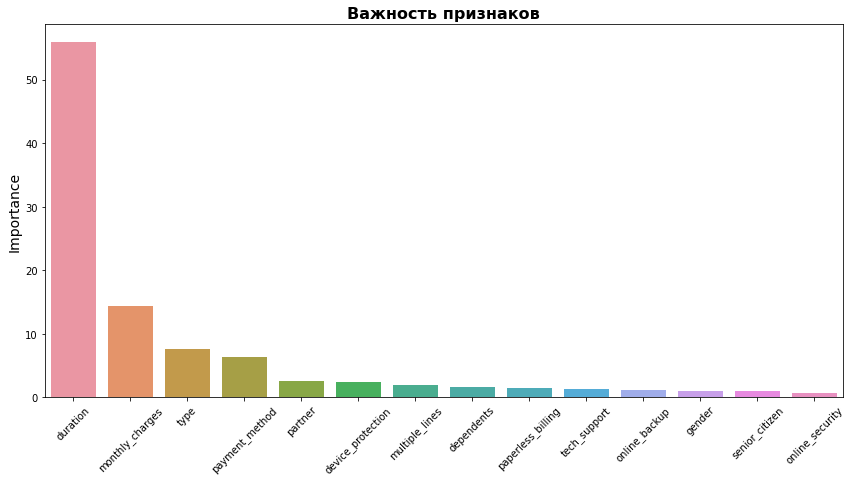

[I 2023-08-24 14:08:27,365] Trial 10 finished with value: 0.8956707081302401 and parameters: {'algorithm': 'CatBoost', 'depth': 5, 'iterations': 605, 'learning_rate': 0.34, 'auto_class_weights': 'Balanced'}. Best is trial 4 with value: 0.9174890505978702.



Training on split 1/5
0:	learn: 0.6237474	test: 0.6413083	best: 0.6413083 (0)	total: 3.28ms	remaining: 2.13s
100:	learn: 0.3358985	test: 0.4831352	best: 0.4797750 (88)	total: 292ms	remaining: 1.59s
200:	learn: 0.2327246	test: 0.4315116	best: 0.4289741 (192)	total: 607ms	remaining: 1.36s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4289741362
bestIteration = 192

Shrink model to first 193 iterations.
Split 1, ROC-AUC : 0.8936049249814977

Training on split 2/5
0:	learn: 0.6299738	test: 0.6312642	best: 0.6312642 (0)	total: 3.21ms	remaining: 2.09s
100:	learn: 0.3122022	test: 0.4580194	best: 0.4580194 (100)	total: 355ms	remaining: 1.93s
200:	learn: 0.2292198	test: 0.4256238	best: 0.4238417 (188)	total: 696ms	remaining: 1.56s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4223804682
bestIteration = 230

Shrink model to first 231 iterations.
Split 2, ROC-AUC : 0.9032261320056515

Training on split 3/5
0:	learn: 0.6321633	test: 0.6352350	best: 0.63

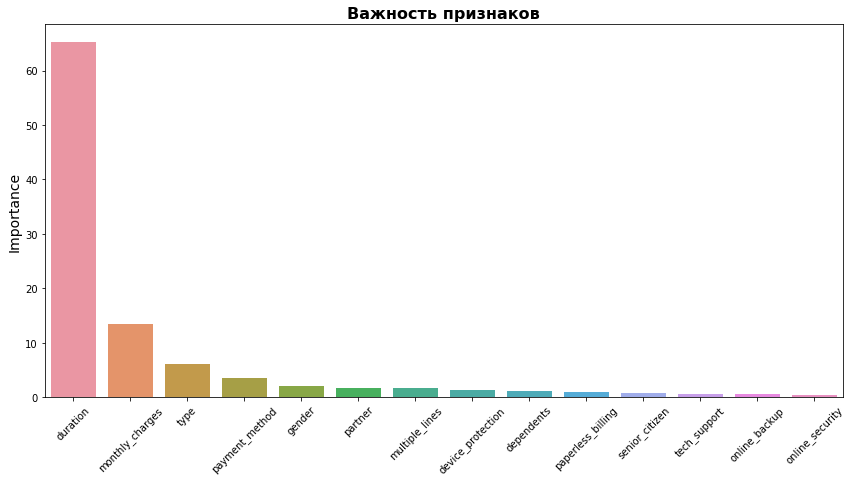

[I 2023-08-24 14:08:37,778] Trial 11 finished with value: 0.9154119674553695 and parameters: {'algorithm': 'CatBoost', 'depth': 3, 'iterations': 651, 'learning_rate': 0.37, 'auto_class_weights': 'Balanced'}. Best is trial 4 with value: 0.9174890505978702.



Training on split 1/5
0:	learn: 0.6084247	test: 0.6300850	best: 0.6300850 (0)	total: 4.62ms	remaining: 2.87s
100:	learn: 0.2906842	test: 0.4579814	best: 0.4563901 (99)	total: 373ms	remaining: 1.92s
200:	learn: 0.1944486	test: 0.4443497	best: 0.4362422 (179)	total: 748ms	remaining: 1.57s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4362422393
bestIteration = 179

Shrink model to first 180 iterations.
Split 1, ROC-AUC : 0.8931474130390904

Training on split 2/5
0:	learn: 0.6154934	test: 0.6203163	best: 0.6203163 (0)	total: 3.96ms	remaining: 2.46s
100:	learn: 0.2752088	test: 0.4768899	best: 0.4751202 (85)	total: 359ms	remaining: 1.85s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4751201638
bestIteration = 85

Shrink model to first 86 iterations.
Split 2, ROC-AUC : 0.8650205207562404

Training on split 3/5
0:	learn: 0.6236145	test: 0.6306633	best: 0.6306633 (0)	total: 4.19ms	remaining: 2.6s
100:	learn: 0.2801410	test: 0.4196134	best: 0.4165631

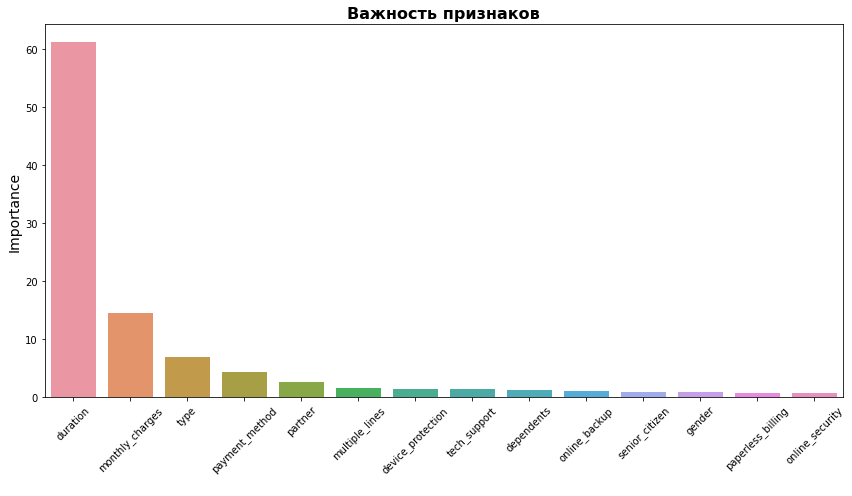

[I 2023-08-24 14:08:46,966] Trial 12 finished with value: 0.9028776641923949 and parameters: {'algorithm': 'CatBoost', 'depth': 4, 'iterations': 622, 'learning_rate': 0.33, 'auto_class_weights': 'Balanced'}. Best is trial 4 with value: 0.9174890505978702.



Training on split 1/5
0:	learn: 0.5880736	test: 0.6173825	best: 0.6173825 (0)	total: 6.69ms	remaining: 4.22s
100:	learn: 0.2426016	test: 0.4561410	best: 0.4521583 (91)	total: 408ms	remaining: 2.14s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4521582578
bestIteration = 91

Shrink model to first 92 iterations.
Split 1, ROC-AUC : 0.8780966157572495

Training on split 2/5
0:	learn: 0.5963390	test: 0.6024483	best: 0.6024483 (0)	total: 5.75ms	remaining: 3.62s
100:	learn: 0.2232454	test: 0.4513317	best: 0.4472396 (87)	total: 393ms	remaining: 2.06s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4396273497
bestIteration = 111

Shrink model to first 112 iterations.
Split 2, ROC-AUC : 0.8937058467334993

Training on split 3/5
0:	learn: 0.6073448	test: 0.6177660	best: 0.6177660 (0)	total: 3.88ms	remaining: 2.45s
100:	learn: 0.2299114	test: 0.4296248	best: 0.4204351 (94)	total: 351ms	remaining: 1.84s
Stopped by overfitting detector  (50 iterations wait)

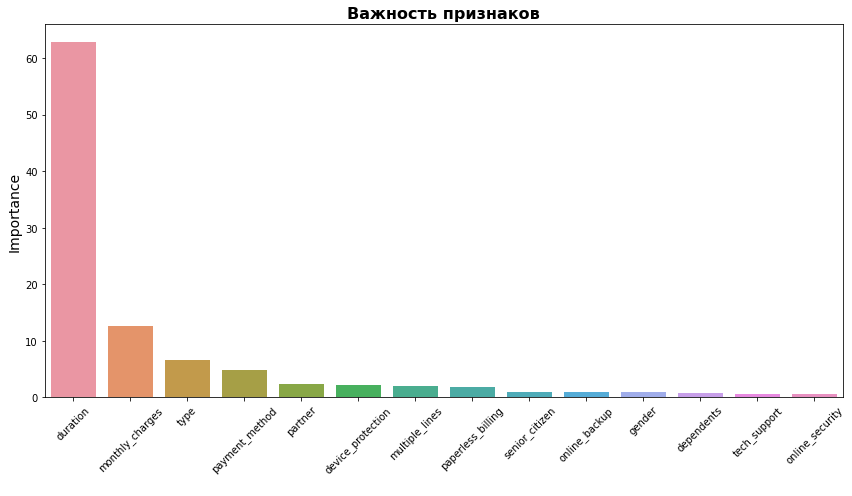

[I 2023-08-24 14:08:55,462] Trial 13 finished with value: 0.9067078594942239 and parameters: {'algorithm': 'CatBoost', 'depth': 4, 'iterations': 631, 'learning_rate': 0.45, 'auto_class_weights': 'Balanced'}. Best is trial 4 with value: 0.9174890505978702.



Training on split 1/5
0:	learn: 0.6340063	test: 0.6483270	best: 0.6483270 (0)	total: 8.02ms	remaining: 5.19s
100:	learn: 0.3470918	test: 0.4712692	best: 0.4712692 (100)	total: 348ms	remaining: 1.88s
200:	learn: 0.2627492	test: 0.4474775	best: 0.4474775 (200)	total: 653ms	remaining: 1.45s
300:	learn: 0.2126318	test: 0.4517178	best: 0.4393798 (260)	total: 950ms	remaining: 1.09s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4393798202
bestIteration = 260

Shrink model to first 261 iterations.
Split 1, ROC-AUC : 0.8897160734710355

Training on split 2/5
0:	learn: 0.6393854	test: 0.6405619	best: 0.6405619 (0)	total: 3.99ms	remaining: 2.58s
100:	learn: 0.3386143	test: 0.4717468	best: 0.4681479 (96)	total: 318ms	remaining: 1.72s
200:	learn: 0.2548051	test: 0.4248607	best: 0.4234457 (196)	total: 620ms	remaining: 1.38s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4234456556
bestIteration = 196

Shrink model to first 197 iterations.
Split 2, ROC-AUC 

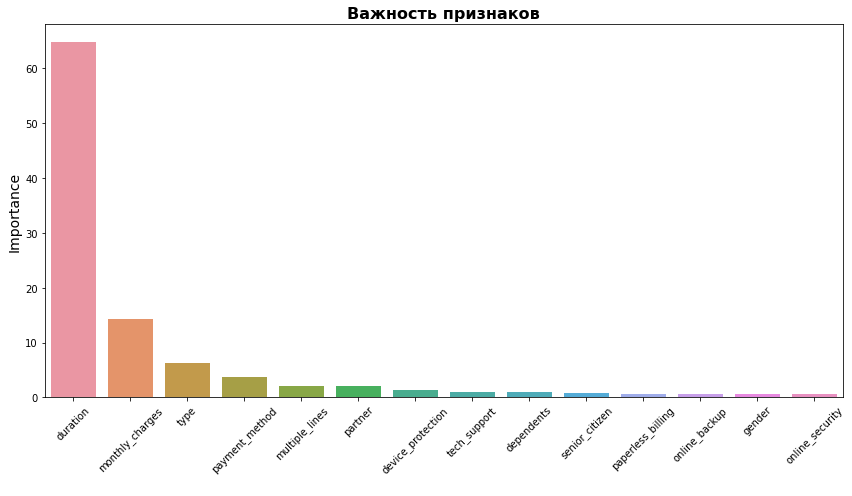

[I 2023-08-24 14:09:05,786] Trial 14 finished with value: 0.9127168297762133 and parameters: {'algorithm': 'CatBoost', 'depth': 3, 'iterations': 648, 'learning_rate': 0.3, 'auto_class_weights': 'Balanced'}. Best is trial 4 with value: 0.9174890505978702.



Training on split 1/5
0:	learn: 0.5942816	test: 0.6210554	best: 0.6210554 (0)	total: 4.87ms	remaining: 1.52s
100:	learn: 0.2558065	test: 0.4629316	best: 0.4569171 (91)	total: 385ms	remaining: 808ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.456825108
bestIteration = 105

Shrink model to first 106 iterations.
Split 1, ROC-AUC : 0.8777063849828431

Training on split 2/5
0:	learn: 0.6022137	test: 0.6079194	best: 0.6079194 (0)	total: 4.17ms	remaining: 1.3s
100:	learn: 0.2499530	test: 0.4720431	best: 0.4662025 (93)	total: 344ms	remaining: 721ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.46127676
bestIteration = 135

Shrink model to first 136 iterations.
Split 2, ROC-AUC : 0.8852923366749648

Training on split 3/5
0:	learn: 0.6122888	test: 0.6215429	best: 0.6215429 (0)	total: 5.19ms	remaining: 1.62s
100:	learn: 0.2481534	test: 0.4454186	best: 0.4442494 (92)	total: 424ms	remaining: 890ms
Stopped by overfitting detector  (50 iterations wait)



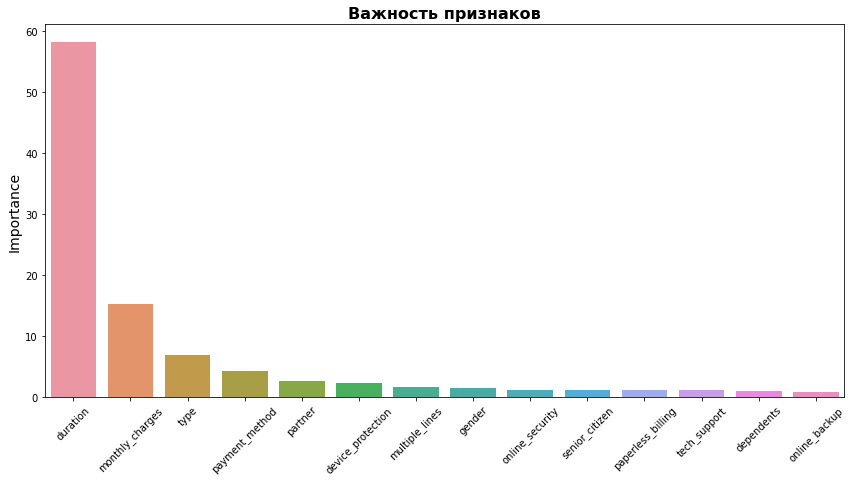

[I 2023-08-24 14:09:15,038] Trial 15 finished with value: 0.9064754719611813 and parameters: {'algorithm': 'CatBoost', 'depth': 4, 'iterations': 313, 'learning_rate': 0.41000000000000003, 'auto_class_weights': 'Balanced'}. Best is trial 4 with value: 0.9174890505978702.



Training on split 1/5
0:	learn: 0.6143953	test: 0.6315960	best: 0.6315960 (0)	total: 5.64ms	remaining: 3.9s
100:	learn: 0.2745942	test: 0.4735805	best: 0.4721267 (96)	total: 509ms	remaining: 2.97s
200:	learn: 0.1676267	test: 0.4410875	best: 0.4325638 (195)	total: 1s	remaining: 2.45s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4325638017
bestIteration = 195

Shrink model to first 196 iterations.
Split 1, ROC-AUC : 0.8978234542151651

Training on split 2/5
0:	learn: 0.6202826	test: 0.6273873	best: 0.6273873 (0)	total: 4.86ms	remaining: 3.35s
100:	learn: 0.2632309	test: 0.4931976	best: 0.4901886 (70)	total: 438ms	remaining: 2.56s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4852384701
bestIteration = 112

Shrink model to first 113 iterations.
Split 2, ROC-AUC : 0.8692996030411089

Training on split 3/5
0:	learn: 0.6234618	test: 0.6334136	best: 0.6334136 (0)	total: 4.67ms	remaining: 3.22s
100:	learn: 0.2763778	test: 0.4713634	best: 0.4704108 

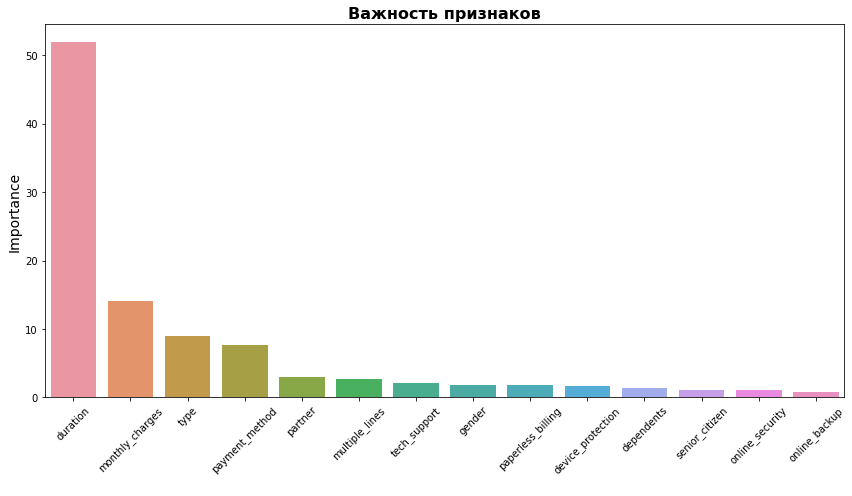

[I 2023-08-24 14:09:26,201] Trial 16 finished with value: 0.9004125632584836 and parameters: {'algorithm': 'CatBoost', 'depth': 5, 'iterations': 691, 'learning_rate': 0.27, 'auto_class_weights': 'Balanced'}. Best is trial 4 with value: 0.9174890505978702.



Training on split 1/5
0:	learn: 0.6197445	test: 0.6386828	best: 0.6386828 (0)	total: 3.25ms	remaining: 1.87s
100:	learn: 0.3211883	test: 0.4622577	best: 0.4622552 (99)	total: 314ms	remaining: 1.48s
200:	learn: 0.2245170	test: 0.4205346	best: 0.4205346 (200)	total: 631ms	remaining: 1.18s
300:	learn: 0.1793051	test: 0.4104450	best: 0.4082616 (292)	total: 938ms	remaining: 857ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4082616337
bestIteration = 292

Shrink model to first 293 iterations.
Split 1, ROC-AUC : 0.9112124066473795

Training on split 2/5
0:	learn: 0.6262912	test: 0.6276127	best: 0.6276127 (0)	total: 3.15ms	remaining: 1.81s
100:	learn: 0.3050324	test: 0.4729294	best: 0.4605414 (90)	total: 305ms	remaining: 1.43s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4605413639
bestIteration = 90

Shrink model to first 91 iterations.
Split 2, ROC-AUC : 0.8722364260243557

Training on split 3/5
0:	learn: 0.6288668	test: 0.6323023	best: 0.63230

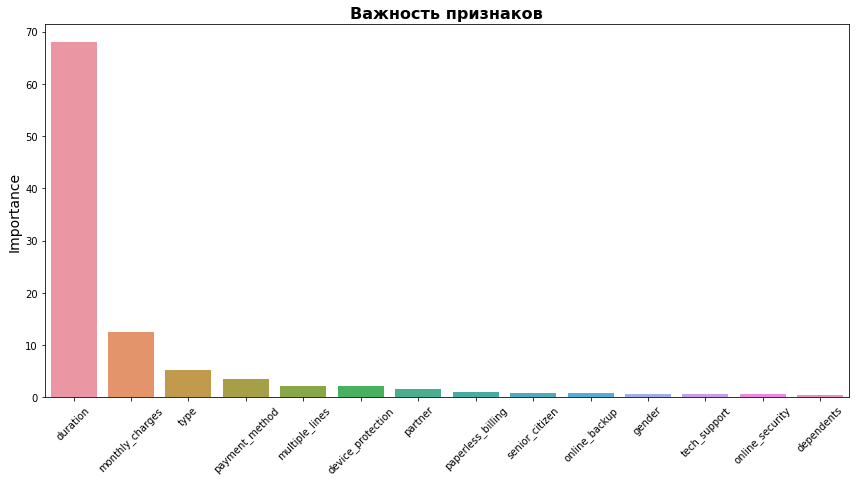

[I 2023-08-24 14:09:37,670] Trial 17 finished with value: 0.9112870320007069 and parameters: {'algorithm': 'CatBoost', 'depth': 3, 'iterations': 576, 'learning_rate': 0.4, 'auto_class_weights': 'Balanced'}. Best is trial 4 with value: 0.9174890505978702.



Training on split 1/5
0:	learn: 0.6365781	test: 0.6498109	best: 0.6498109 (0)	total: 4.14ms	remaining: 1.92s
100:	learn: 0.3694198	test: 0.4941385	best: 0.4941385 (100)	total: 375ms	remaining: 1.35s
200:	learn: 0.2678134	test: 0.4414841	best: 0.4399018 (196)	total: 740ms	remaining: 972ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4351260476
bestIteration = 233

Shrink model to first 234 iterations.
Split 1, ROC-AUC : 0.8895949673686336

Training on split 2/5
0:	learn: 0.6415918	test: 0.6447508	best: 0.6447508 (0)	total: 4.51ms	remaining: 2.09s
100:	learn: 0.3508225	test: 0.5067044	best: 0.5035530 (97)	total: 353ms	remaining: 1.27s
200:	learn: 0.2495723	test: 0.4703597	best: 0.4703597 (200)	total: 719ms	remaining: 944ms
300:	learn: 0.1950249	test: 0.4801995	best: 0.4639210 (257)	total: 1.07s	remaining: 585ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4639210241
bestIteration = 257

Shrink model to first 258 iterations.
Split 2, ROC-AUC 

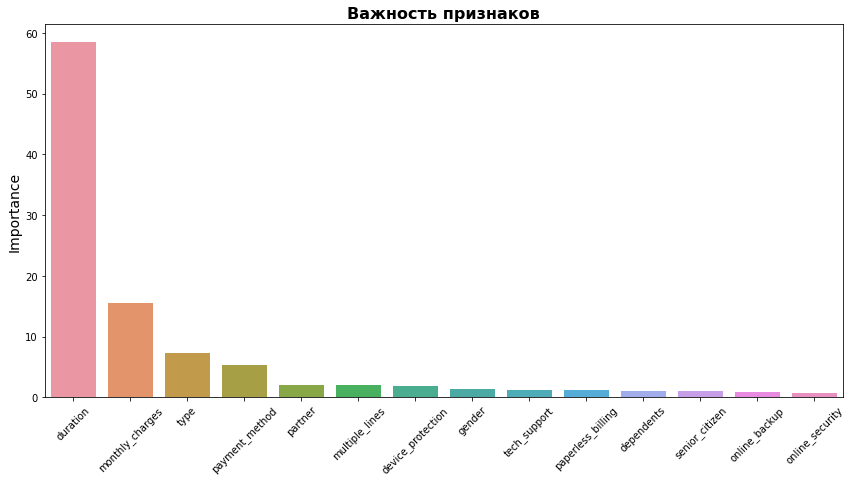

[I 2023-08-24 14:09:49,867] Trial 18 finished with value: 0.9077842852267578 and parameters: {'algorithm': 'CatBoost', 'depth': 4, 'iterations': 465, 'learning_rate': 0.2, 'auto_class_weights': 'Balanced'}. Best is trial 4 with value: 0.9174890505978702.



Training on split 1/5
0:	learn: 0.5972131	test: 0.6194531	best: 0.6194531 (0)	total: 5.83ms	remaining: 4.49s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5484592395
bestIteration = 15

Shrink model to first 16 iterations.
Split 1, ROC-AUC : 0.7977393527551638

Training on split 2/5
0:	learn: 0.6040301	test: 0.6130563	best: 0.6130563 (0)	total: 7.34ms	remaining: 5.66s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5217267617
bestIteration = 12

Shrink model to first 13 iterations.
Split 2, ROC-AUC : 0.8151618112090426

Training on split 3/5
0:	learn: 0.5818110	test: 0.6072812	best: 0.6072812 (0)	total: 10.1ms	remaining: 7.77s
100:	learn: 0.1222294	test: 0.5448644	best: 0.5012477 (61)	total: 889ms	remaining: 5.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5012476732
bestIteration = 61

Shrink model to first 62 iterations.
Split 3, ROC-AUC : 0.8636455936103965

Training on split 4/5
0:	learn: 0.5938676	test: 0.6032062	b

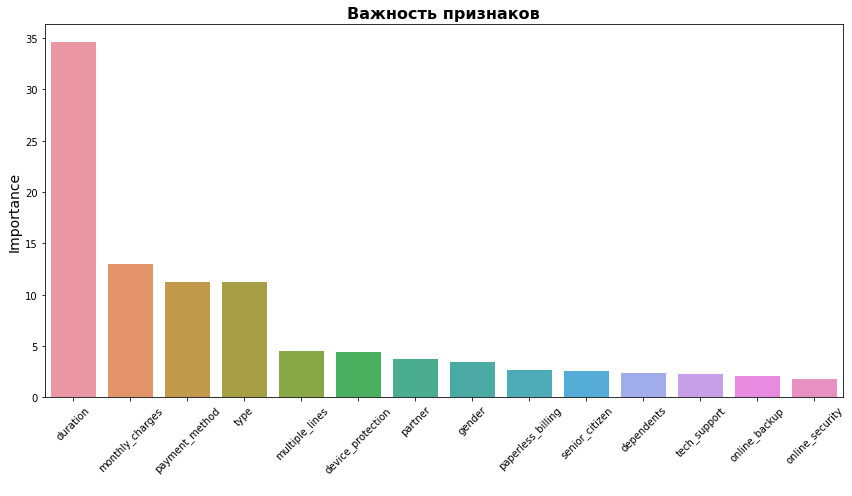

[I 2023-08-24 14:09:58,693] Trial 19 finished with value: 0.8400663570652117 and parameters: {'algorithm': 'CatBoost', 'depth': 8, 'iterations': 771, 'learning_rate': 0.35000000000000003, 'auto_class_weights': 'Balanced'}. Best is trial 4 with value: 0.9174890505978702.



Training on split 1/5
0:	learn: 0.5747636	test: 0.6051118	best: 0.6051118 (0)	total: 5.68ms	remaining: 3.81s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5528788661
bestIteration = 12

Shrink model to first 13 iterations.
Split 1, ROC-AUC : 0.7967604117607482

Training on split 2/5
0:	learn: 0.5825043	test: 0.5944807	best: 0.5944807 (0)	total: 6.46ms	remaining: 4.33s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5195908151
bestIteration = 20

Shrink model to first 21 iterations.
Split 2, ROC-AUC : 0.8244701608019914

Training on split 3/5
0:	learn: 0.5691302	test: 0.5919354	best: 0.5919354 (0)	total: 11.5ms	remaining: 7.71s
100:	learn: 0.0950813	test: 0.5735706	best: 0.5025500 (51)	total: 622ms	remaining: 3.51s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5025499747
bestIteration = 51

Shrink model to first 52 iterations.
Split 3, ROC-AUC : 0.8645119805062949

Training on split 4/5
0:	learn: 0.5716032	test: 0.5839981	

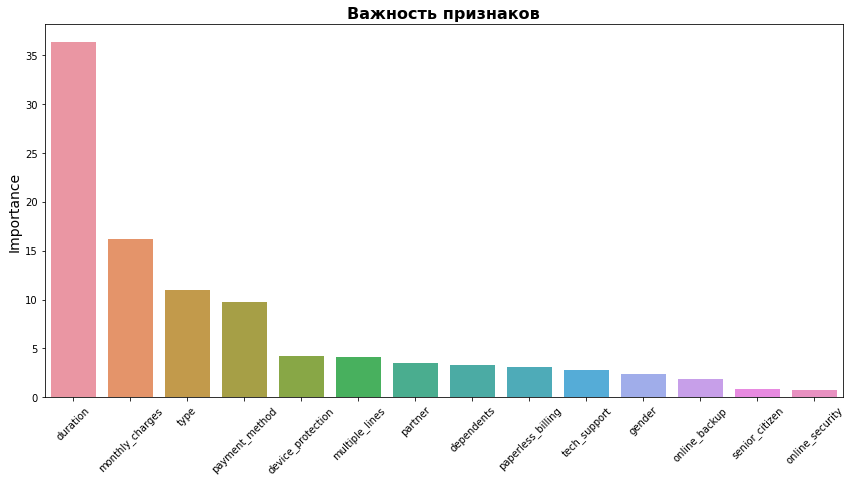

[I 2023-08-24 14:10:07,167] Trial 20 finished with value: 0.8538386419255707 and parameters: {'algorithm': 'CatBoost', 'depth': 7, 'iterations': 671, 'learning_rate': 0.48000000000000004, 'auto_class_weights': 'Balanced'}. Best is trial 4 with value: 0.9174890505978702.



Training on split 1/5
0:	learn: 0.6355783	test: 0.6494332	best: 0.6494332 (0)	total: 3.01ms	remaining: 1.98s
100:	learn: 0.3668530	test: 0.4854423	best: 0.4854423 (100)	total: 303ms	remaining: 1.68s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4431442614
bestIteration = 149

Shrink model to first 150 iterations.
Split 1, ROC-AUC : 0.881003162214896

Training on split 2/5
0:	learn: 0.6408246	test: 0.6419800	best: 0.6419800 (0)	total: 3ms	remaining: 1.98s
100:	learn: 0.3479008	test: 0.4700592	best: 0.4700592 (100)	total: 296ms	remaining: 1.64s
200:	learn: 0.2558486	test: 0.4447966	best: 0.4386334 (186)	total: 602ms	remaining: 1.38s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4386334002
bestIteration = 186

Shrink model to first 187 iterations.
Split 2, ROC-AUC : 0.8852317836237636

Training on split 3/5
0:	learn: 0.6420635	test: 0.6442474	best: 0.6442474 (0)	total: 4.46ms	remaining: 2.95s
100:	learn: 0.3615721	test: 0.4620868	best: 0.462086

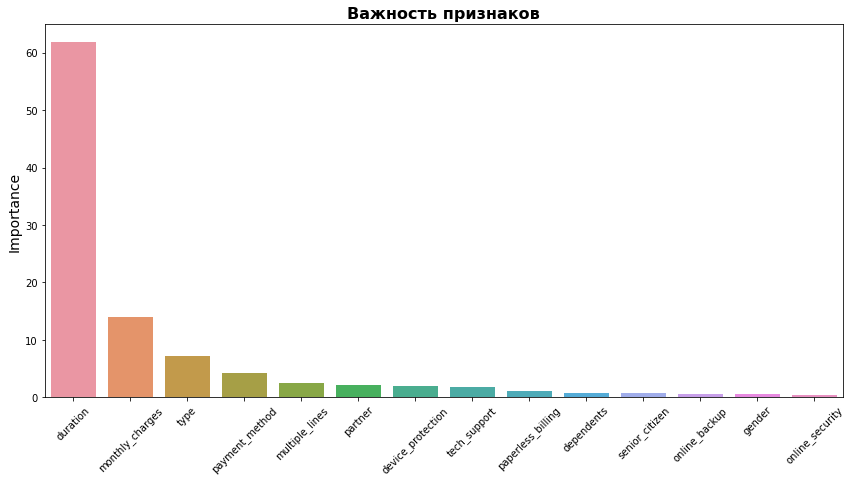

[I 2023-08-24 14:10:17,837] Trial 21 finished with value: 0.910080615809129 and parameters: {'algorithm': 'CatBoost', 'depth': 3, 'iterations': 661, 'learning_rate': 0.29000000000000004, 'auto_class_weights': 'Balanced'}. Best is trial 4 with value: 0.9174890505978702.



Training on split 1/5
0:	learn: 0.6324610	test: 0.6472470	best: 0.6472470 (0)	total: 3.14ms	remaining: 1.79s
100:	learn: 0.3432782	test: 0.4842074	best: 0.4842074 (100)	total: 304ms	remaining: 1.42s
200:	learn: 0.2592634	test: 0.4436419	best: 0.4433887 (199)	total: 609ms	remaining: 1.12s
300:	learn: 0.2085094	test: 0.4294161	best: 0.4241074 (268)	total: 922ms	remaining: 827ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.424107402
bestIteration = 268

Shrink model to first 269 iterations.
Split 1, ROC-AUC : 0.8988595842023818

Training on split 2/5
0:	learn: 0.6379700	test: 0.6391664	best: 0.6391664 (0)	total: 3.13ms	remaining: 1.78s
100:	learn: 0.3327789	test: 0.4751092	best: 0.4736147 (98)	total: 323ms	remaining: 1.5s
200:	learn: 0.2502482	test: 0.4284342	best: 0.4284342 (200)	total: 627ms	remaining: 1.15s
300:	learn: 0.1997150	test: 0.4200882	best: 0.4170778 (293)	total: 969ms	remaining: 869ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0

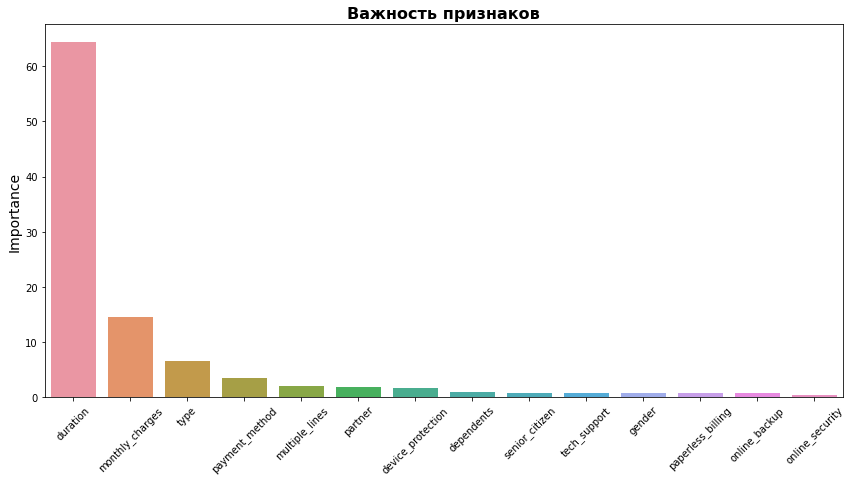

[I 2023-08-24 14:10:28,261] Trial 22 finished with value: 0.9200712694010921 and parameters: {'algorithm': 'CatBoost', 'depth': 3, 'iterations': 571, 'learning_rate': 0.31, 'auto_class_weights': 'Balanced'}. Best is trial 22 with value: 0.9200712694010921.



Training on split 1/5
0:	learn: 0.6010601	test: 0.6252842	best: 0.6252842 (0)	total: 4.01ms	remaining: 2.34s
100:	learn: 0.2704512	test: 0.4743716	best: 0.4731314 (79)	total: 368ms	remaining: 1.76s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4580968815
bestIteration = 116

Shrink model to first 117 iterations.
Split 1, ROC-AUC : 0.8817903518805088

Training on split 2/5
0:	learn: 0.6085951	test: 0.6138723	best: 0.6138723 (0)	total: 6.74ms	remaining: 3.93s
100:	learn: 0.2523426	test: 0.4588251	best: 0.4569379 (83)	total: 441ms	remaining: 2.11s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4485923118
bestIteration = 116

Shrink model to first 117 iterations.
Split 2, ROC-AUC : 0.8859550561797753

Training on split 3/5
0:	learn: 0.6177060	test: 0.6258353	best: 0.6258353 (0)	total: 4.84ms	remaining: 2.82s
100:	learn: 0.2612488	test: 0.4196964	best: 0.4196964 (100)	total: 374ms	remaining: 1.79s
Stopped by overfitting detector  (50 iterations wa

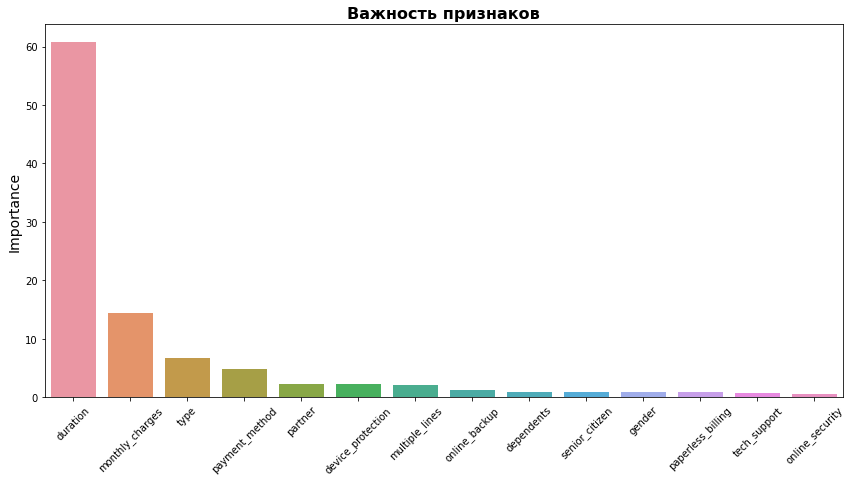

[I 2023-08-24 14:10:36,869] Trial 23 finished with value: 0.9069469427194076 and parameters: {'algorithm': 'CatBoost', 'depth': 4, 'iterations': 584, 'learning_rate': 0.37, 'auto_class_weights': 'Balanced'}. Best is trial 22 with value: 0.9200712694010921.



Training on split 1/5
0:	learn: 0.6438438	test: 0.6553575	best: 0.6553575 (0)	total: 3.48ms	remaining: 1.94s
100:	learn: 0.3927703	test: 0.5064882	best: 0.5059752 (99)	total: 322ms	remaining: 1.46s
200:	learn: 0.3066632	test: 0.4649612	best: 0.4602896 (175)	total: 654ms	remaining: 1.16s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4530658666
bestIteration = 221

Shrink model to first 222 iterations.
Split 1, ROC-AUC : 0.8767577205140282

Training on split 2/5
0:	learn: 0.6483800	test: 0.6494117	best: 0.6494117 (0)	total: 3.17ms	remaining: 1.77s
100:	learn: 0.3686153	test: 0.4808544	best: 0.4808544 (100)	total: 308ms	remaining: 1.4s
200:	learn: 0.2813428	test: 0.4431142	best: 0.4403935 (191)	total: 645ms	remaining: 1.15s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4403934797
bestIteration = 191

Shrink model to first 192 iterations.
Split 2, ROC-AUC : 0.883933257081343

Training on split 3/5
0:	learn: 0.6491147	test: 0.6508056	best: 0.6508

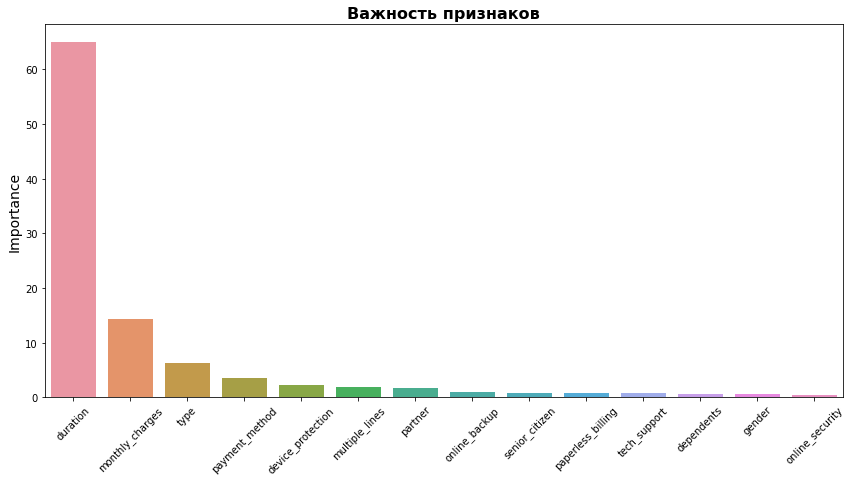

[I 2023-08-24 14:10:48,567] Trial 24 finished with value: 0.909562048233302 and parameters: {'algorithm': 'CatBoost', 'depth': 3, 'iterations': 559, 'learning_rate': 0.24000000000000002, 'auto_class_weights': 'Balanced'}. Best is trial 22 with value: 0.9200712694010921.



Training on split 1/5
0:	learn: 0.6147677	test: 0.6355323	best: 0.6355323 (0)	total: 3.18ms	remaining: 1.55s
100:	learn: 0.2985104	test: 0.4675145	best: 0.4565760 (97)	total: 305ms	remaining: 1.17s
200:	learn: 0.2135577	test: 0.4377731	best: 0.4375576 (199)	total: 615ms	remaining: 884ms
300:	learn: 0.1704083	test: 0.4431220	best: 0.4263970 (252)	total: 910ms	remaining: 572ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4263970349
bestIteration = 252

Shrink model to first 253 iterations.
Split 1, ROC-AUC : 0.9023649330552379

Training on split 2/5
0:	learn: 0.6217035	test: 0.6230503	best: 0.6230503 (0)	total: 3.16ms	remaining: 1.54s
100:	learn: 0.2914293	test: 0.4484460	best: 0.4481411 (97)	total: 297ms	remaining: 1.14s
200:	learn: 0.2017965	test: 0.4324387	best: 0.4189258 (180)	total: 610ms	remaining: 877ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4189257942
bestIteration = 180

Shrink model to first 181 iterations.
Split 2, ROC-AUC :

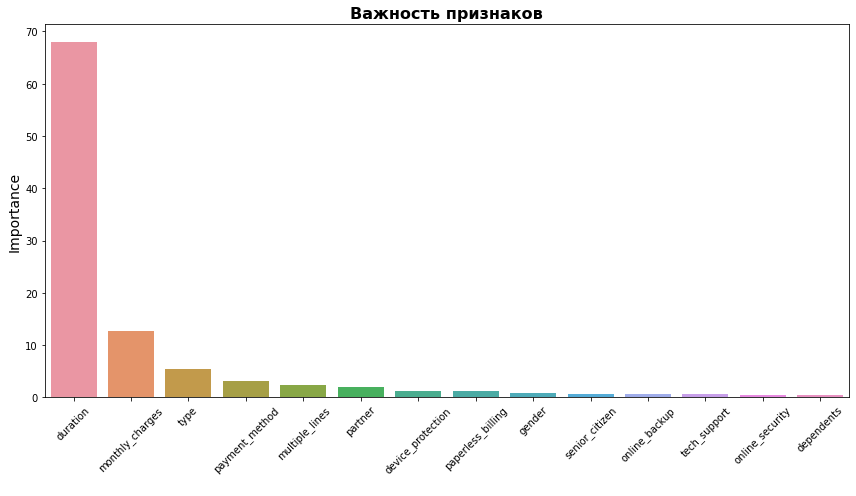

[I 2023-08-24 14:10:57,963] Trial 25 finished with value: 0.9200256884363126 and parameters: {'algorithm': 'CatBoost', 'depth': 3, 'iterations': 490, 'learning_rate': 0.44, 'auto_class_weights': 'Balanced'}. Best is trial 22 with value: 0.9200712694010921.



Training on split 1/5
0:	learn: 0.6440214	test: 0.6552896	best: 0.6552896 (0)	total: 4.43ms	remaining: 2.13s
100:	learn: 0.3875631	test: 0.5018331	best: 0.5018331 (100)	total: 344ms	remaining: 1.3s
200:	learn: 0.2897856	test: 0.4455419	best: 0.4455419 (200)	total: 720ms	remaining: 1.01s
300:	learn: 0.2359247	test: 0.4283491	best: 0.4283491 (300)	total: 1.06s	remaining: 640ms
400:	learn: 0.1952098	test: 0.4179351	best: 0.4179351 (400)	total: 1.42s	remaining: 287ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4174662192
bestIteration = 407

Shrink model to first 408 iterations.
Split 1, ROC-AUC : 0.901618112090426

Training on split 2/5
0:	learn: 0.6484328	test: 0.6511653	best: 0.6511653 (0)	total: 4.42ms	remaining: 2.13s
100:	learn: 0.3735434	test: 0.4877193	best: 0.4877193 (100)	total: 345ms	remaining: 1.3s
200:	learn: 0.2799411	test: 0.4610900	best: 0.4610900 (200)	total: 735ms	remaining: 1.03s
300:	learn: 0.2236922	test: 0.4480494	best: 0.4441603 (295)	total: 

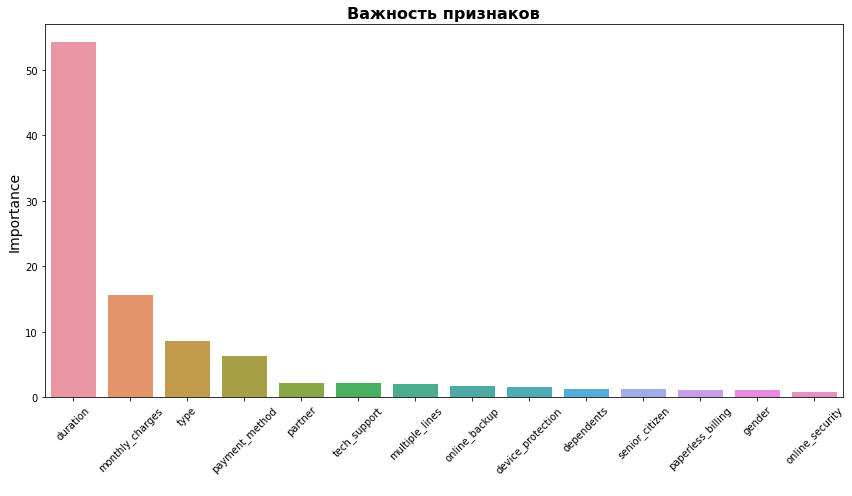

[I 2023-08-24 14:11:13,274] Trial 26 finished with value: 0.9115938746576159 and parameters: {'algorithm': 'CatBoost', 'depth': 4, 'iterations': 482, 'learning_rate': 0.17, 'auto_class_weights': 'Balanced'}. Best is trial 22 with value: 0.9200712694010921.



Training on split 1/5
0:	learn: 0.5809801	test: 0.6088453	best: 0.6088453 (0)	total: 7.11ms	remaining: 2.93s
100:	learn: 0.1988679	test: 0.4821138	best: 0.4584421 (72)	total: 425ms	remaining: 1.31s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4584420852
bestIteration = 72

Shrink model to first 73 iterations.
Split 1, ROC-AUC : 0.8771681356388347

Training on split 2/5
0:	learn: 0.5885030	test: 0.5995938	best: 0.5995938 (0)	total: 4.75ms	remaining: 1.96s
100:	learn: 0.1837954	test: 0.4939737	best: 0.4897026 (96)	total: 462ms	remaining: 1.43s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4890874535
bestIteration = 123

Shrink model to first 124 iterations.
Split 2, ROC-AUC : 0.8831056987149297

Training on split 3/5
0:	learn: 0.5947115	test: 0.6123018	best: 0.6123018 (0)	total: 4.78ms	remaining: 1.97s
100:	learn: 0.1907897	test: 0.4693341	best: 0.4633236 (76)	total: 430ms	remaining: 1.33s
Stopped by overfitting detector  (50 iterations wait)

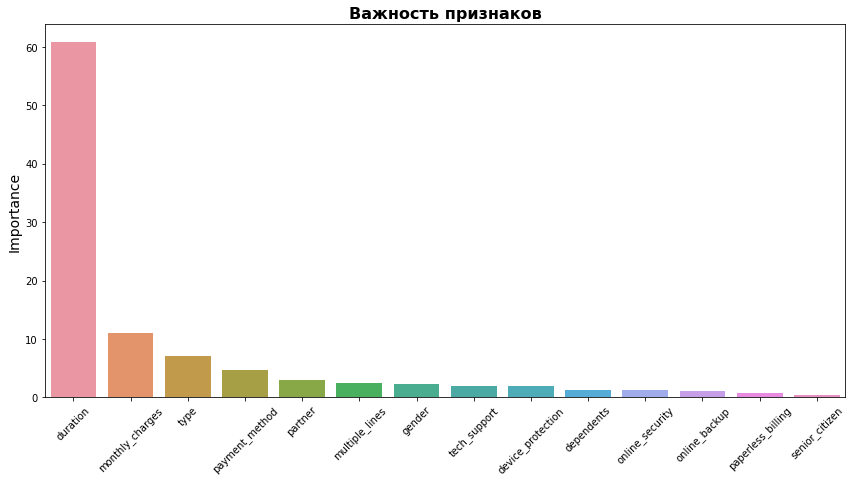

[I 2023-08-24 14:11:22,638] Trial 27 finished with value: 0.8984931044908965 and parameters: {'algorithm': 'CatBoost', 'depth': 5, 'iterations': 413, 'learning_rate': 0.44, 'auto_class_weights': 'Balanced'}. Best is trial 22 with value: 0.9200712694010921.



Training on split 1/5
0:	learn: 0.6324610	test: 0.6472470	best: 0.6472470 (0)	total: 2.99ms	remaining: 1.49s
100:	learn: 0.3432782	test: 0.4842074	best: 0.4842074 (100)	total: 281ms	remaining: 1.11s
200:	learn: 0.2592634	test: 0.4436419	best: 0.4433887 (199)	total: 594ms	remaining: 884ms
300:	learn: 0.2085094	test: 0.4294161	best: 0.4241074 (268)	total: 893ms	remaining: 590ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.424107402
bestIteration = 268

Shrink model to first 269 iterations.
Split 1, ROC-AUC : 0.8988595842023818

Training on split 2/5
0:	learn: 0.6379700	test: 0.6391664	best: 0.6391664 (0)	total: 3.02ms	remaining: 1.51s
100:	learn: 0.3327789	test: 0.4751092	best: 0.4736147 (98)	total: 285ms	remaining: 1.12s
200:	learn: 0.2502482	test: 0.4284342	best: 0.4284342 (200)	total: 584ms	remaining: 869ms
300:	learn: 0.1997150	test: 0.4200882	best: 0.4170778 (293)	total: 903ms	remaining: 597ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 

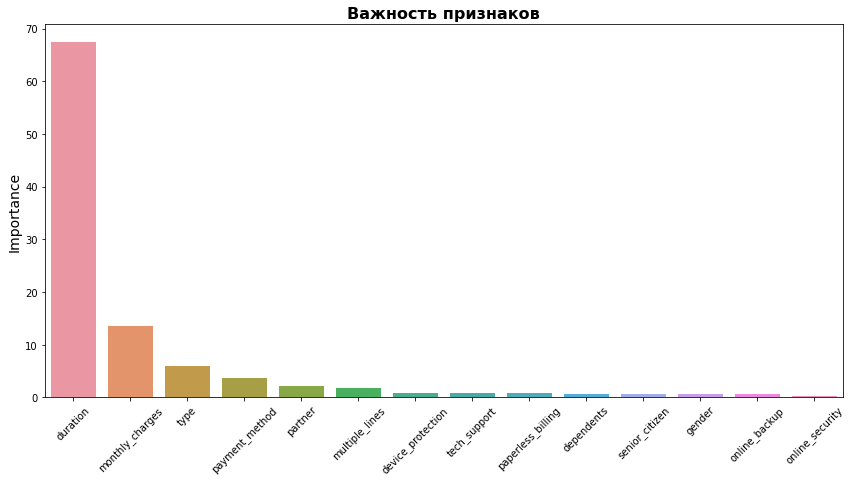

[I 2023-08-24 14:13:04,060] Trial 37 finished with value: 0.9165500608367669 and parameters: {'algorithm': 'CatBoost', 'depth': 3, 'iterations': 517, 'learning_rate': 0.46, 'auto_class_weights': 'Balanced'}. Best is trial 22 with value: 0.9200712694010921.



Training on split 1/5
0:	learn: 0.6896364	test: 0.6902776	best: 0.6902776 (0)	total: 4.67ms	remaining: 2.77s
100:	learn: 0.5477277	test: 0.5830524	best: 0.5830524 (100)	total: 397ms	remaining: 1.94s
200:	learn: 0.5112351	test: 0.5609761	best: 0.5609761 (200)	total: 752ms	remaining: 1.47s
300:	learn: 0.4946983	test: 0.5541974	best: 0.5541638 (299)	total: 1.12s	remaining: 1.09s
400:	learn: 0.4819698	test: 0.5491250	best: 0.5491250 (400)	total: 1.55s	remaining: 746ms
500:	learn: 0.4725223	test: 0.5459176	best: 0.5459176 (500)	total: 1.9s	remaining: 352ms
593:	learn: 0.4653671	test: 0.5437774	best: 0.5437774 (593)	total: 2.22s	remaining: 0us

bestTest = 0.5437773939
bestIteration = 593

Split 1, ROC-AUC : 0.7981194913543699

Training on split 2/5
0:	learn: 0.6899398	test: 0.6902202	best: 0.6902202 (0)	total: 4.47ms	remaining: 2.65s
100:	learn: 0.5506099	test: 0.5677955	best: 0.5677955 (100)	total: 405ms	remaining: 1.98s
200:	learn: 0.5134296	test: 0.5400981	best: 0.5400981 (200)	total: 77

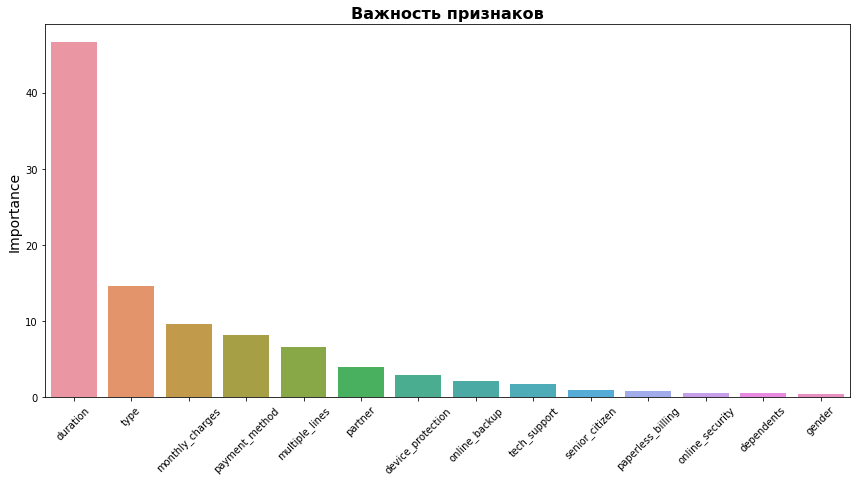

[I 2023-08-24 14:13:22,768] Trial 38 finished with value: 0.8276674186485563 and parameters: {'algorithm': 'CatBoost', 'depth': 5, 'iterations': 594, 'learning_rate': 0.01, 'auto_class_weights': 'Balanced'}. Best is trial 22 with value: 0.9200712694010921.



Training on split 1/5
0:	learn: 0.6624313	test: 0.6692037	best: 0.6692037 (0)	total: 3ms	remaining: 1.62s
100:	learn: 0.4434577	test: 0.5294884	best: 0.5288655 (99)	total: 282ms	remaining: 1.23s
200:	learn: 0.3679816	test: 0.4863163	best: 0.4854553 (192)	total: 566ms	remaining: 957ms
300:	learn: 0.3235927	test: 0.4620171	best: 0.4604178 (293)	total: 870ms	remaining: 694ms
400:	learn: 0.2903410	test: 0.4490820	best: 0.4483247 (391)	total: 1.18s	remaining: 412ms
500:	learn: 0.2605367	test: 0.4401668	best: 0.4401464 (499)	total: 1.47s	remaining: 117ms
540:	learn: 0.2514200	test: 0.4412263	best: 0.4387298 (519)	total: 1.58s	remaining: 0us

bestTest = 0.4387298285
bestIteration = 519

Shrink model to first 520 iterations.
Split 1, ROC-AUC : 0.8875428917446008

Training on split 2/5
0:	learn: 0.6653094	test: 0.6660003	best: 0.6660003 (0)	total: 3.71ms	remaining: 2s
100:	learn: 0.4267915	test: 0.5002148	best: 0.4997754 (99)	total: 317ms	remaining: 1.38s
200:	learn: 0.3574435	test: 0.4774924	

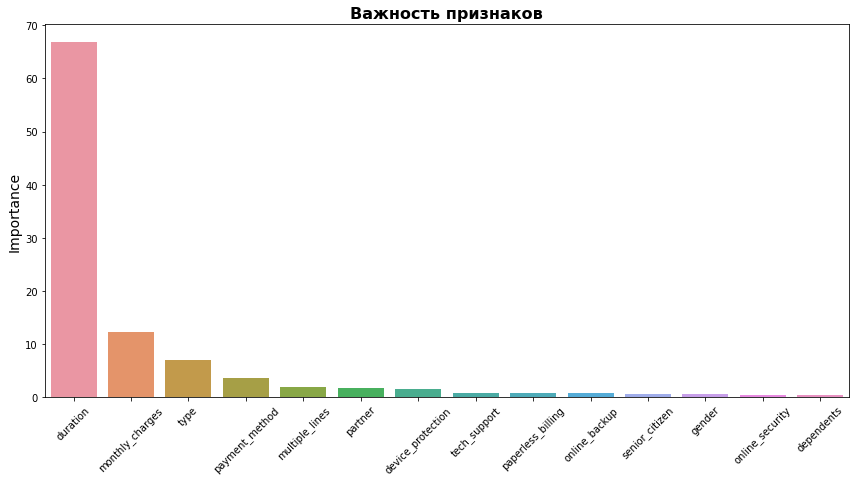

[I 2023-08-24 14:13:37,877] Trial 39 finished with value: 0.9080032894816836 and parameters: {'algorithm': 'CatBoost', 'depth': 3, 'iterations': 541, 'learning_rate': 0.14, 'auto_class_weights': 'Balanced'}. Best is trial 22 with value: 0.9200712694010921.



Training on split 1/5
0:	learn: 0.5942816	test: 0.6210554	best: 0.6210554 (0)	total: 6.48ms	remaining: 3.66s
100:	learn: 0.2558065	test: 0.4629316	best: 0.4569171 (91)	total: 381ms	remaining: 1.75s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.456825108
bestIteration = 105

Shrink model to first 106 iterations.
Split 1, ROC-AUC : 0.8777063849828431

Training on split 2/5
0:	learn: 0.6022137	test: 0.6079194	best: 0.6079194 (0)	total: 6.56ms	remaining: 3.71s
100:	learn: 0.2499530	test: 0.4720431	best: 0.4662025 (93)	total: 403ms	remaining: 1.85s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.46127676
bestIteration = 135

Shrink model to first 136 iterations.
Split 2, ROC-AUC : 0.8852923366749648

Training on split 3/5
0:	learn: 0.6122888	test: 0.6215429	best: 0.6215429 (0)	total: 5.39ms	remaining: 3.04s
100:	learn: 0.2481534	test: 0.4454186	best: 0.4442494 (92)	total: 370ms	remaining: 1.71s
Stopped by overfitting detector  (50 iterations wait)


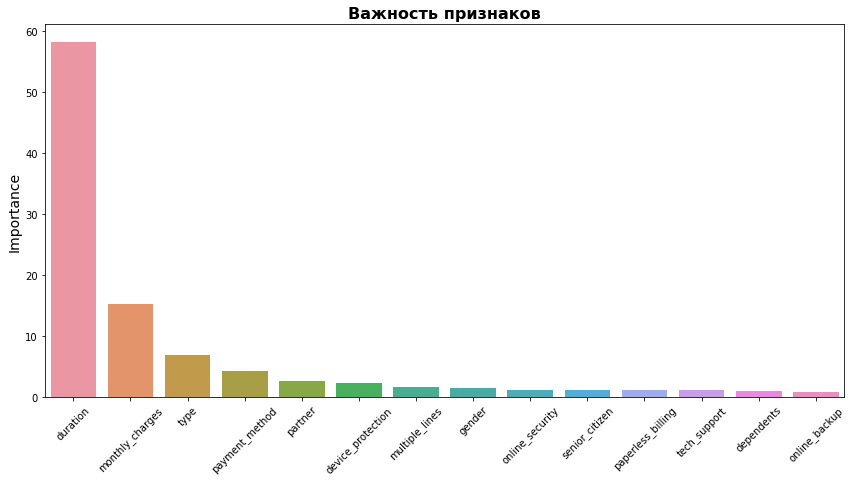

[I 2023-08-24 14:13:47,278] Trial 40 finished with value: 0.9064754719611813 and parameters: {'algorithm': 'CatBoost', 'depth': 4, 'iterations': 566, 'learning_rate': 0.41000000000000003, 'auto_class_weights': 'Balanced'}. Best is trial 22 with value: 0.9200712694010921.



Training on split 1/5
0:	learn: 0.6455785	test: 0.6566216	best: 0.6566216 (0)	total: 3.96ms	remaining: 2.41s
100:	learn: 0.3789529	test: 0.4712869	best: 0.4712869 (100)	total: 299ms	remaining: 1.5s
200:	learn: 0.2973142	test: 0.4334866	best: 0.4320832 (198)	total: 612ms	remaining: 1.24s
300:	learn: 0.2461944	test: 0.4086187	best: 0.4086187 (300)	total: 951ms	remaining: 973ms
400:	learn: 0.2139054	test: 0.4027344	best: 0.3993603 (370)	total: 1.27s	remaining: 661ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.398588021
bestIteration = 414

Shrink model to first 415 iterations.
Split 1, ROC-AUC : 0.90999461750656

Training on split 2/5
0:	learn: 0.6499634	test: 0.6509666	best: 0.6509666 (0)	total: 3.23ms	remaining: 1.97s
100:	learn: 0.3846669	test: 0.4992513	best: 0.4951727 (90)	total: 286ms	remaining: 1.44s
200:	learn: 0.2957083	test: 0.4442282	best: 0.4441848 (198)	total: 590ms	remaining: 1.2s
300:	learn: 0.2385135	test: 0.4350394	best: 0.4343002 (298)	total: 902

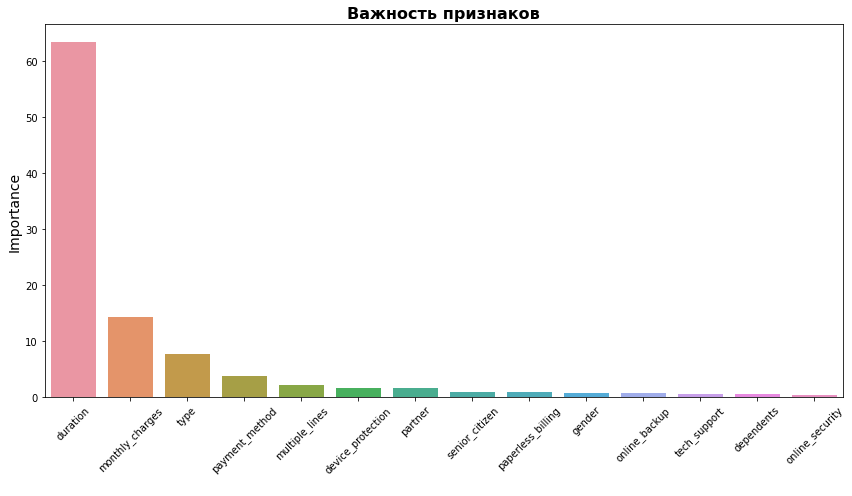

[I 2023-08-24 14:14:00,398] Trial 41 finished with value: 0.9180094501669466 and parameters: {'algorithm': 'CatBoost', 'depth': 3, 'iterations': 609, 'learning_rate': 0.23, 'auto_class_weights': 'Balanced'}. Best is trial 22 with value: 0.9200712694010921.



Training on split 1/5
0:	learn: 0.6455785	test: 0.6566216	best: 0.6566216 (0)	total: 3.97ms	remaining: 2.04s
100:	learn: 0.3789529	test: 0.4712869	best: 0.4712869 (100)	total: 300ms	remaining: 1.23s
200:	learn: 0.2973142	test: 0.4334866	best: 0.4320832 (198)	total: 601ms	remaining: 942ms
300:	learn: 0.2461944	test: 0.4086187	best: 0.4086187 (300)	total: 896ms	remaining: 640ms
400:	learn: 0.2139054	test: 0.4027344	best: 0.3993603 (370)	total: 1.22s	remaining: 350ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.398588021
bestIteration = 414

Shrink model to first 415 iterations.
Split 1, ROC-AUC : 0.90999461750656

Training on split 2/5
0:	learn: 0.6499634	test: 0.6509666	best: 0.6509666 (0)	total: 3.21ms	remaining: 1.65s
100:	learn: 0.3846669	test: 0.4992513	best: 0.4951727 (90)	total: 292ms	remaining: 1.2s
200:	learn: 0.2957083	test: 0.4442282	best: 0.4441848 (198)	total: 613ms	remaining: 961ms
300:	learn: 0.2385135	test: 0.4350394	best: 0.4343002 (298)	total: 91

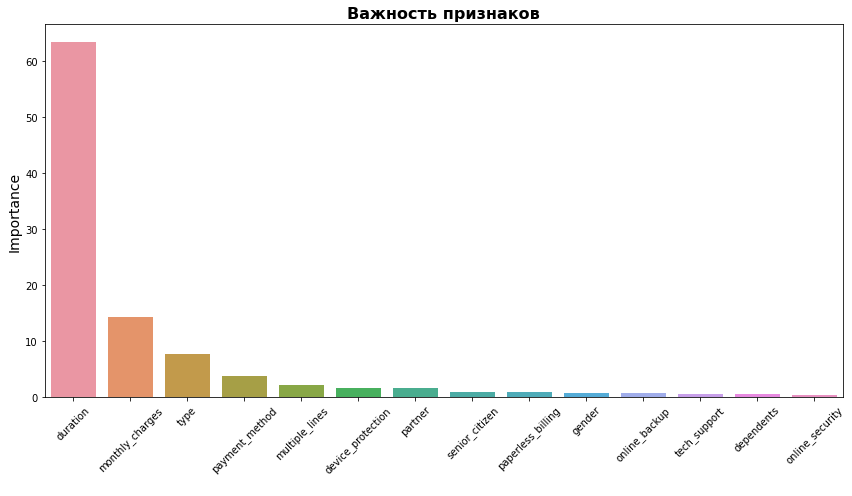

[I 2023-08-24 14:14:14,874] Trial 42 finished with value: 0.9172581302806597 and parameters: {'algorithm': 'CatBoost', 'depth': 3, 'iterations': 516, 'learning_rate': 0.23, 'auto_class_weights': 'Balanced'}. Best is trial 22 with value: 0.9200712694010921.



Training on split 1/5
0:	learn: 0.6080593	test: 0.6315417	best: 0.6315417 (0)	total: 2.91ms	remaining: 1.76s
100:	learn: 0.2993707	test: 0.5029284	best: 0.4986773 (97)	total: 297ms	remaining: 1.49s
200:	learn: 0.1975025	test: 0.4457530	best: 0.4415162 (188)	total: 629ms	remaining: 1.27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4394767023
bestIteration = 208

Shrink model to first 209 iterations.
Split 1, ROC-AUC : 0.8987620265087802

Training on split 2/5
0:	learn: 0.6155013	test: 0.6168523	best: 0.6168523 (0)	total: 2.98ms	remaining: 1.8s
100:	learn: 0.2796635	test: 0.4620060	best: 0.4620060 (100)	total: 309ms	remaining: 1.55s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4478168503
bestIteration = 113

Shrink model to first 114 iterations.
Split 2, ROC-AUC : 0.8822108591805153

Training on split 3/5
0:	learn: 0.6194023	test: 0.6241675	best: 0.6241675 (0)	total: 3.49ms	remaining: 2.11s
100:	learn: 0.2813616	test: 0.4242045	best: 0.4224

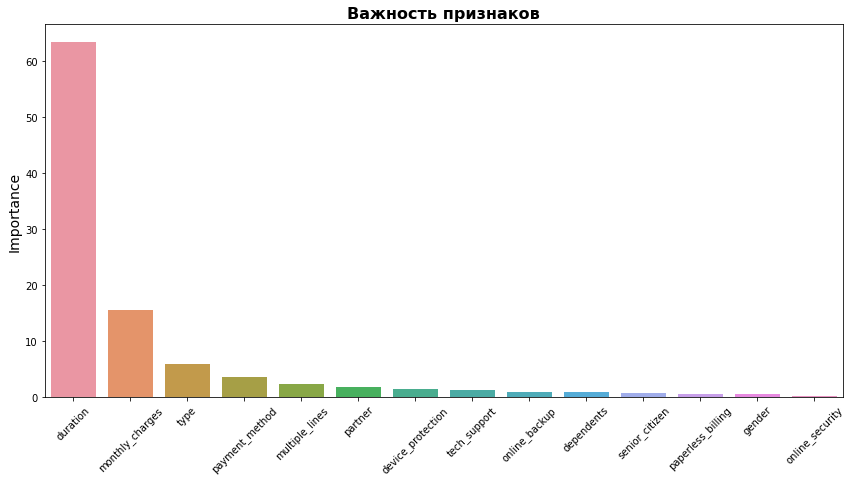

[I 2023-08-24 14:14:24,044] Trial 43 finished with value: 0.913560896347281 and parameters: {'algorithm': 'CatBoost', 'depth': 3, 'iterations': 606, 'learning_rate': 0.5, 'auto_class_weights': 'Balanced'}. Best is trial 22 with value: 0.9200712694010921.



Training on split 1/5
0:	learn: 0.6509473	test: 0.6605740	best: 0.6605740 (0)	total: 2.95ms	remaining: 1.38s
100:	learn: 0.4052597	test: 0.5113149	best: 0.5113149 (100)	total: 292ms	remaining: 1.06s
200:	learn: 0.3198871	test: 0.4618877	best: 0.4618877 (200)	total: 605ms	remaining: 806ms
300:	learn: 0.2693208	test: 0.4341970	best: 0.4329328 (294)	total: 910ms	remaining: 508ms
400:	learn: 0.2314023	test: 0.4296530	best: 0.4242340 (364)	total: 1.24s	remaining: 210ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4242340241
bestIteration = 364

Shrink model to first 365 iterations.
Split 1, ROC-AUC : 0.8965249276727444

Training on split 2/5
0:	learn: 0.6548590	test: 0.6557694	best: 0.6557694 (0)	total: 3.68ms	remaining: 1.72s
100:	learn: 0.3979554	test: 0.4948652	best: 0.4946691 (98)	total: 318ms	remaining: 1.16s
200:	learn: 0.3119197	test: 0.4501099	best: 0.4495044 (196)	total: 607ms	remaining: 809ms
300:	learn: 0.2591852	test: 0.4387009	best: 0.4299851 (255)	total

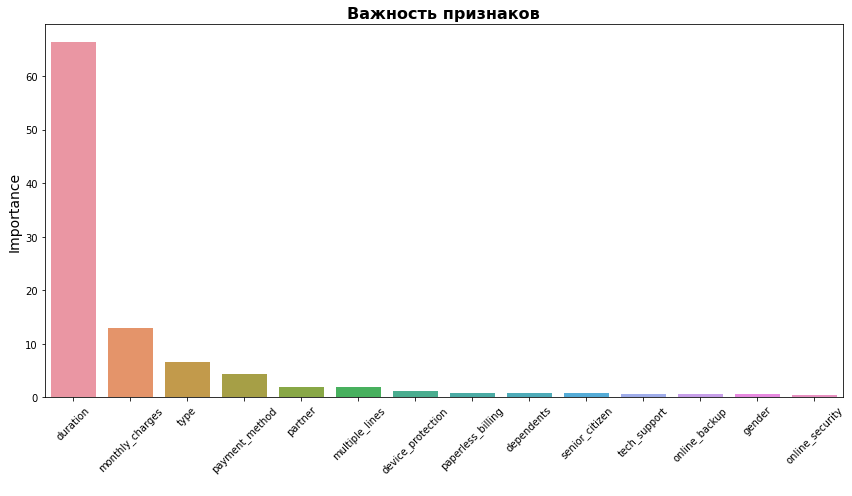

[I 2023-08-24 14:14:37,563] Trial 44 finished with value: 0.9123853768029123 and parameters: {'algorithm': 'CatBoost', 'depth': 3, 'iterations': 469, 'learning_rate': 0.2, 'auto_class_weights': 'Balanced'}. Best is trial 22 with value: 0.9200712694010921.



Training on split 1/5
0:	learn: 0.6371773	test: 0.6505654	best: 0.6505654 (0)	total: 3.55ms	remaining: 1.9s
100:	learn: 0.3663744	test: 0.4928473	best: 0.4891377 (97)	total: 327ms	remaining: 1.41s
200:	learn: 0.2716241	test: 0.4527990	best: 0.4514915 (186)	total: 636ms	remaining: 1.06s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4441022656
bestIteration = 218

Shrink model to first 219 iterations.
Split 1, ROC-AUC : 0.8843806768485502

Training on split 2/5
0:	learn: 0.6422877	test: 0.6434208	best: 0.6434208 (0)	total: 4.81ms	remaining: 2.57s
100:	learn: 0.3391718	test: 0.4667656	best: 0.4664207 (99)	total: 369ms	remaining: 1.59s
200:	learn: 0.2601740	test: 0.4355665	best: 0.4351640 (198)	total: 668ms	remaining: 1.11s
300:	learn: 0.2150604	test: 0.4324524	best: 0.4289945 (281)	total: 970ms	remaining: 754ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4282897641
bestIteration = 323

Shrink model to first 324 iterations.
Split 2, ROC-AUC : 

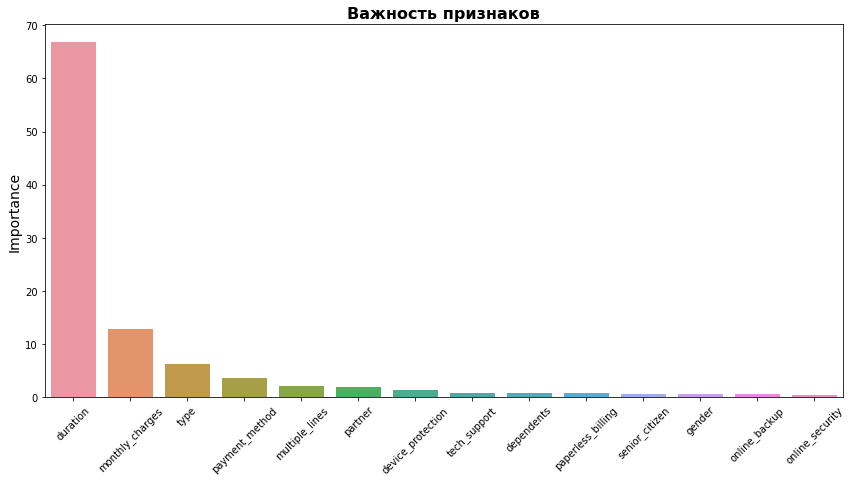

[I 2023-08-24 14:14:49,672] Trial 45 finished with value: 0.9163041076368991 and parameters: {'algorithm': 'CatBoost', 'depth': 3, 'iterations': 535, 'learning_rate': 0.28, 'auto_class_weights': 'Balanced'}. Best is trial 22 with value: 0.9200712694010921.



Training on split 1/5
0:	learn: 0.6249704	test: 0.6414613	best: 0.6414613 (0)	total: 4.1ms	remaining: 2.52s
100:	learn: 0.3282429	test: 0.4749971	best: 0.4749971 (100)	total: 406ms	remaining: 2.07s
200:	learn: 0.2310766	test: 0.4356492	best: 0.4349561 (171)	total: 793ms	remaining: 1.64s
300:	learn: 0.1752649	test: 0.4160803	best: 0.4140093 (284)	total: 1.16s	remaining: 1.21s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.414009293
bestIteration = 284

Shrink model to first 285 iterations.
Split 1, ROC-AUC : 0.9076364125681222

Training on split 2/5
0:	learn: 0.6308778	test: 0.6347117	best: 0.6347117 (0)	total: 4ms	remaining: 2.46s
100:	learn: 0.3081909	test: 0.4774195	best: 0.4764905 (99)	total: 357ms	remaining: 1.82s
200:	learn: 0.2173568	test: 0.4544591	best: 0.4497244 (187)	total: 715ms	remaining: 1.48s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4497244272
bestIteration = 187

Shrink model to first 188 iterations.
Split 2, ROC-AUC : 0.8

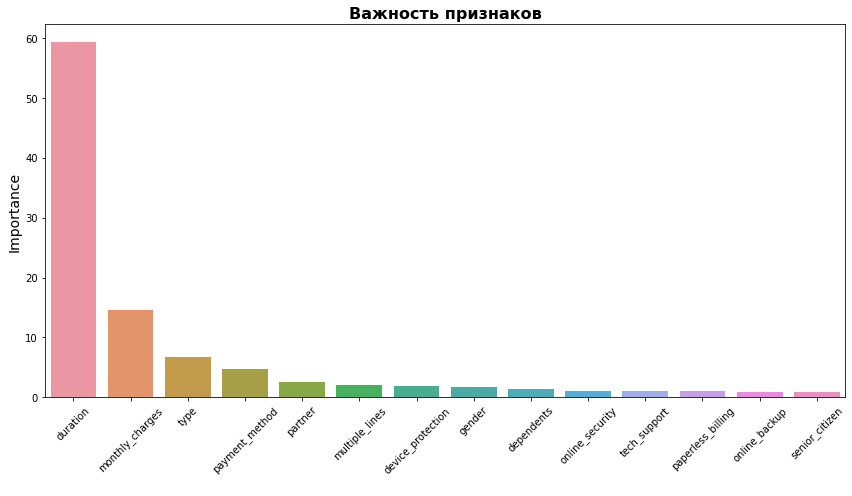

[I 2023-08-24 14:15:01,245] Trial 46 finished with value: 0.9149882014771056 and parameters: {'algorithm': 'CatBoost', 'depth': 4, 'iterations': 616, 'learning_rate': 0.25, 'auto_class_weights': 'Balanced'}. Best is trial 22 with value: 0.9200712694010921.



Training on split 1/5
0:	learn: 0.5975985	test: 0.6230993	best: 0.6230993 (0)	total: 4.81ms	remaining: 2.42s
100:	learn: 0.2653477	test: 0.4616779	best: 0.4616497 (99)	total: 359ms	remaining: 1.44s
200:	learn: 0.1716000	test: 0.4647484	best: 0.4493228 (157)	total: 755ms	remaining: 1.14s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4493227583
bestIteration = 157

Shrink model to first 158 iterations.
Split 1, ROC-AUC : 0.8884444593958151

Training on split 2/5
0:	learn: 0.6053404	test: 0.6108350	best: 0.6108350 (0)	total: 4.44ms	remaining: 2.24s
100:	learn: 0.2509075	test: 0.4505776	best: 0.4505776 (100)	total: 420ms	remaining: 1.68s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4505775645
bestIteration = 100

Shrink model to first 101 iterations.
Split 2, ROC-AUC : 0.8826515508309225

Training on split 3/5
0:	learn: 0.6149371	test: 0.6236234	best: 0.6236234 (0)	total: 4.86ms	remaining: 2.45s
100:	learn: 0.2515465	test: 0.4311874	best: 0.428

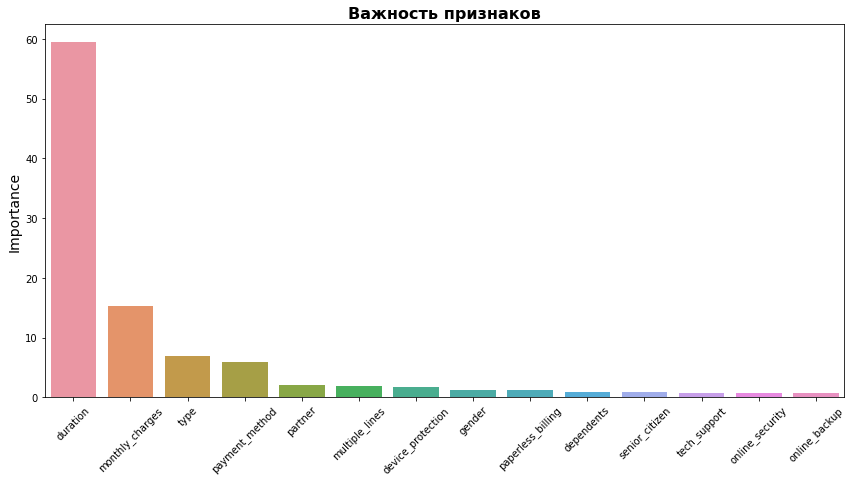

[I 2023-08-24 14:15:13,246] Trial 47 finished with value: 0.9073287187639071 and parameters: {'algorithm': 'CatBoost', 'depth': 4, 'iterations': 505, 'learning_rate': 0.39, 'auto_class_weights': 'Balanced'}. Best is trial 22 with value: 0.9200712694010921.



Training on split 1/5
0:	learn: 0.6265463	test: 0.6431853	best: 0.6431853 (0)	total: 3.19ms	remaining: 1.75s
100:	learn: 0.3291053	test: 0.4687697	best: 0.4687078 (99)	total: 310ms	remaining: 1.38s
200:	learn: 0.2424284	test: 0.4231464	best: 0.4231464 (200)	total: 607ms	remaining: 1.05s
300:	learn: 0.1902974	test: 0.4092854	best: 0.4091669 (299)	total: 947ms	remaining: 780ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4040810364
bestIteration = 315

Shrink model to first 316 iterations.
Split 1, ROC-AUC : 0.9107750790553725

Training on split 2/5
0:	learn: 0.6325452	test: 0.6338090	best: 0.6338090 (0)	total: 3.42ms	remaining: 1.87s
100:	learn: 0.3194824	test: 0.4787529	best: 0.4784365 (98)	total: 371ms	remaining: 1.65s
200:	learn: 0.2266342	test: 0.4273329	best: 0.4260614 (184)	total: 707ms	remaining: 1.22s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4247164006
bestIteration = 211

Shrink model to first 212 iterations.
Split 2, ROC-AUC :

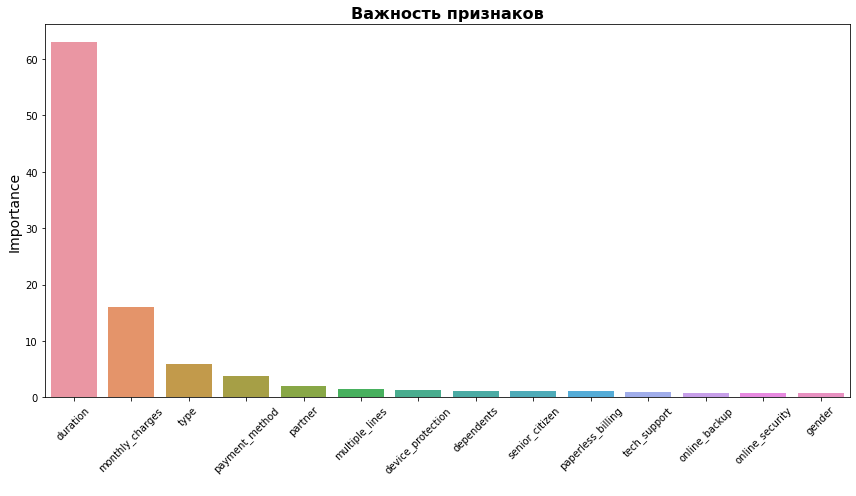

[I 2023-08-24 14:15:26,126] Trial 48 finished with value: 0.9188669364938731 and parameters: {'algorithm': 'CatBoost', 'depth': 3, 'iterations': 549, 'learning_rate': 0.35000000000000003, 'auto_class_weights': 'Balanced'}. Best is trial 22 with value: 0.9200712694010921.



Training on split 1/5
0:	learn: 0.6279853	test: 0.6441621	best: 0.6441621 (0)	total: 3.23ms	remaining: 1.36s
100:	learn: 0.3369826	test: 0.4969929	best: 0.4969929 (100)	total: 311ms	remaining: 990ms
200:	learn: 0.2516893	test: 0.4483283	best: 0.4472111 (198)	total: 620ms	remaining: 685ms
300:	learn: 0.1990645	test: 0.4371821	best: 0.4284050 (291)	total: 920ms	remaining: 373ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4284049803
bestIteration = 291

Shrink model to first 292 iterations.
Split 1, ROC-AUC : 0.8979109197335665

Training on split 2/5
0:	learn: 0.6338660	test: 0.6351148	best: 0.6351148 (0)	total: 3.1ms	remaining: 1.31s
100:	learn: 0.3291758	test: 0.4701238	best: 0.4701238 (100)	total: 328ms	remaining: 1.04s
200:	learn: 0.2482871	test: 0.4281572	best: 0.4268389 (193)	total: 687ms	remaining: 759ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4216527931
bestIteration = 235

Shrink model to first 236 iterations.
Split 2, ROC-AUC 

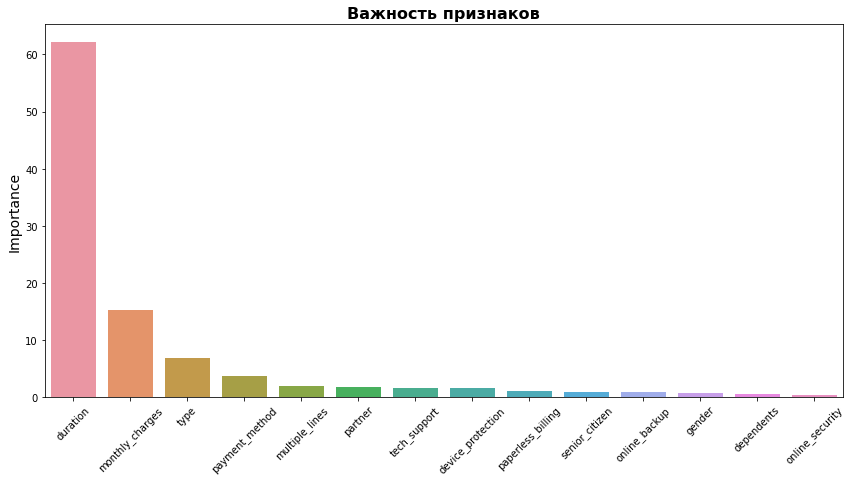

[I 2023-08-24 14:15:37,570] Trial 49 finished with value: 0.9185559515867412 and parameters: {'algorithm': 'CatBoost', 'depth': 3, 'iterations': 423, 'learning_rate': 0.34, 'auto_class_weights': 'Balanced'}. Best is trial 22 with value: 0.9200712694010921.


CPU times: user 4min 50s, sys: 15.3 s, total: 5min 6s
Wall time: 9min 27s


In [56]:
%%time
def catboostuna(trial):
    
    classifier = trial.suggest_categorical('algorithm', ["CatBoost"]) 
    param_cb = {
        "depth":               trial.suggest_int("depth", 3, 8),
        "iterations":          trial.suggest_int("iterations", 300, 800),
        "learning_rate":       trial.suggest_float("learning_rate", 0.01, 0.5, step=0.01),
        "auto_class_weights":  trial.suggest_categorical("auto_class_weights", ["Balanced"]),              
        "random_seed":         RANDOM_STATE,
        "task_type":           'CPU',        
        "cat_features":        cat_features,
        "loss_function":       "Logloss"
               }
    
        
    classifier_obj = CatBoostClassifier(**param_cb)

    # Инициализация KFold Cross-Validation
    n_splits = 5
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

    roc_auc_scores = [] 

    # Обучение с KFold Cross-Validation 
    for split, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
        print(f'\nTraining on split {split+1}/{n_splits}')

        X_train1, X_val1 = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train1, y_val1 = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Масштабируем численные признаки
        scaler = StandardScaler()
        X_train1.loc[:, num_features] = scaler.fit_transform(X_train1[num_features])
        X_val1.loc[:, num_features] = scaler.transform(X_val1[num_features])
        

        classifier_obj.fit(X_train1, y_train1,
                           eval_set=(X_val1, y_val1),
                           early_stopping_rounds=50, verbose=100)   

        # Предсказания на валидационном фолде
        y_pred = classifier_obj.predict_proba(X_val1)[:, 1]

        # Подсчёт ROC-AUC
        roc_auc = roc_auc_score(y_val1, y_pred)
        roc_auc_scores.append(roc_auc)

        print(f'Split {split+1}, ROC-AUC : {roc_auc}')

    # Вывод на экран среднего значения ROC-AUC по всем фолдам
    rauc = sum(roc_auc_scores) / n_splits
    
    print('Average ROC AUC:', rauc)
    
    # График важности признаков
    importance_df = pd.DataFrame({'Feature': classifier_obj.feature_names_,\
                                  'Importance': classifier_obj.feature_importances_})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 7))
    sns.barplot(data=importance_df, x='Feature', y='Importance')
    plt.xlabel(' ')
    plt.ylabel('Importance', fontsize=14)
    plt.xticks(rotation=45)
    plt.title('Важность признаков', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return  rauc

# Запишем сэмплер
sampler = optuna.samplers.TPESampler(seed=111)

# Создадим объект обучения и оптимизируем
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(catboostuna, n_trials=50, show_progress_bar=False) 

In [57]:
cb_best_score = round((study.best_value), 2)

# лучшее значение метрики AUC-ROC 
print(f'best_score: {cb_best_score}')
# лучшие гиперпараметры
print(f'best_params: {study.best_params}')

best_score: 0.92
best_params: {'algorithm': 'CatBoost', 'depth': 3, 'iterations': 571, 'learning_rate': 0.31, 'auto_class_weights': 'Balanced'}



Training on split 1/5
0:	learn: 0.6324610	test: 0.6472470	best: 0.6472470 (0)	total: 2.93ms	remaining: 1.67s
100:	learn: 0.3432782	test: 0.4842074	best: 0.4842074 (100)	total: 288ms	remaining: 1.34s
200:	learn: 0.2592634	test: 0.4436419	best: 0.4433887 (199)	total: 595ms	remaining: 1.09s
300:	learn: 0.2085094	test: 0.4294161	best: 0.4241074 (268)	total: 915ms	remaining: 820ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.424107402
bestIteration = 268

Shrink model to first 269 iterations.
Split 1, ROC-AUC : 0.8988595842023818

Training on split 2/5
0:	learn: 0.6379700	test: 0.6391664	best: 0.6391664 (0)	total: 4.57ms	remaining: 2.6s
100:	learn: 0.3327789	test: 0.4751092	best: 0.4736147 (98)	total: 361ms	remaining: 1.68s
200:	learn: 0.2502482	test: 0.4284342	best: 0.4284342 (200)	total: 649ms	remaining: 1.19s
300:	learn: 0.1997150	test: 0.4200882	best: 0.4170778 (293)	total: 954ms	remaining: 855ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0

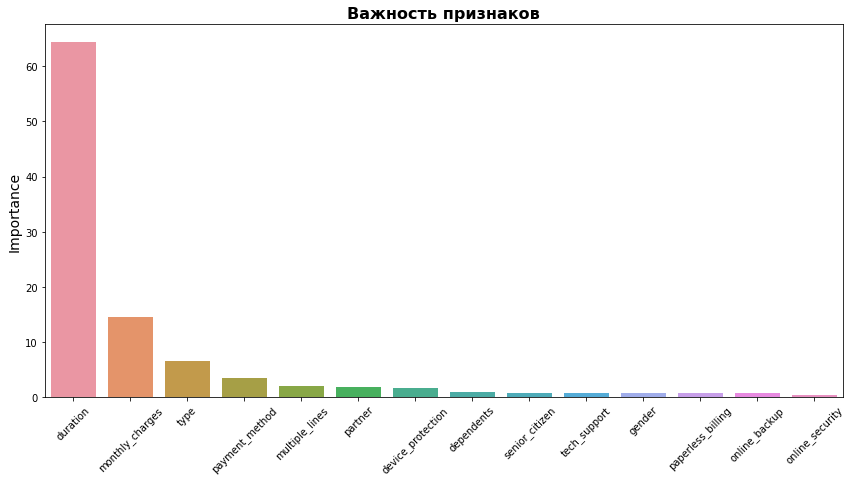

0.9200712694010921

In [58]:
# Посмотрим график важности признаков
catboostuna(study.best_trial)

Из графика видно, что признаки - срок пользования услугами, ежемесяячные траты на услуги по договру и тип оплаты — являются самыми значимыми.

### Анализ моделей

In [69]:
# Занесем результаты в таблицу
result = pd.DataFrame([random_cv_lr_best_score,random_cv_rf_best_score, random_cv_lgbm_best_score, cb_best_score], 
                       index=['LogisticRegression','RandomForestClassifier','LGBMClassifier','CatBoostClassifier'], 
                       columns=['AUC-ROC'])
result    

,AUC-ROC
LogisticRegression,0.75
RandomForestClassifier,0.81
LGBMClassifier,0.86
CatBoostClassifier,0.92


Для обучения моделей мы применили следующие библиотеки: LogisticRegression, RandomForestClassifier, LightGBMClassifier и CatBoostClassifier. Для моделей мы подбирали оптимальные гиперпараметры с целью получения максимальной оценки метрики AUC-ROC. Для обучения моделей LogisticRegression, RandomForestClassifier, LightGBMClassifier мы применяли Pipeline, для модели CatBoostClassifier мы использовали библиотеку Optuna.
Мы занесли результаты обучения моделей в таблицу и изучили их. Лучшей моделью стала CatBoostClassifier с максимальным показалем AUC-ROC на тренировочной выборке 0.92
Изучив график важности признаков лучшей модели, можно сделать вывод, что признаки - срок пользования услугами, ежемесяячные траты на услуги по договру и тип оплаты - являются самыми значимыми.

## Тестирование лучшей модели

Проверим результаты выбранной модели на тестовой выборке.

In [60]:
# Численные признаки
num_features_test = X_test.select_dtypes(exclude='object').columns.to_list()
num_features_test

['duration', 'monthly_charges']

In [61]:
# Категориальные признаки 
cat_features_test = X_test.select_dtypes(include='object').columns.to_list()
cat_features_test

['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'multiple_lines']

In [62]:
# Масштабируем признаки
scaler = StandardScaler()
X_train.loc[:, num_features] = scaler.fit_transform(X_train[num_features])
X_test.loc[:, num_features_test] = scaler.transform(X_test[num_features_test])

In [63]:
# Инициируем модель с лучшими параметрами
model_cb_best = CatBoostClassifier(depth=3,
                                   iterations=571,
                                   learning_rate=0.31,
                                   cat_features = cat_features_test,
                                   auto_class_weights = 'Balanced',
                                   random_state=RANDOM_STATE)
                                   
model_cb_best.fit(X_train, y_train)

0:	learn: 0.6387854	total: 3.75ms	remaining: 2.14s
1:	learn: 0.6075265	total: 9.78ms	remaining: 2.78s
2:	learn: 0.5824630	total: 14.7ms	remaining: 2.78s
3:	learn: 0.5644849	total: 19.8ms	remaining: 2.8s
4:	learn: 0.5515555	total: 25.6ms	remaining: 2.89s
5:	learn: 0.5464511	total: 30.7ms	remaining: 2.89s
6:	learn: 0.5404555	total: 36.1ms	remaining: 2.91s
7:	learn: 0.5337996	total: 41ms	remaining: 2.88s
8:	learn: 0.5287487	total: 45.7ms	remaining: 2.86s
9:	learn: 0.5207745	total: 51.1ms	remaining: 2.87s
10:	learn: 0.5186550	total: 55.3ms	remaining: 2.81s
11:	learn: 0.5166557	total: 58.5ms	remaining: 2.72s
12:	learn: 0.5134781	total: 62.5ms	remaining: 2.68s
13:	learn: 0.5114496	total: 65.8ms	remaining: 2.62s
14:	learn: 0.5049808	total: 69.5ms	remaining: 2.58s
15:	learn: 0.5023970	total: 73.4ms	remaining: 2.54s
16:	learn: 0.5006451	total: 76.6ms	remaining: 2.5s
17:	learn: 0.4972036	total: 80.4ms	remaining: 2.47s
18:	learn: 0.4967692	total: 83.9ms	remaining: 2.44s
19:	learn: 0.4965716	total

In [64]:
pred = model_cb_best.predict_proba(X_test)[:, 1]
AUC_ROC = roc_auc_score(y_test, pred)
print('Метрика AUC-ROC на тестовой выборке для модели CatBoostClassifier составила', round((AUC_ROC),2))

Метрика AUC-ROC на тестовой выборке для модели CatBoostClassifier составила 0.94


### Проверка модели на адекватность

Проверим нашу модель на адекватность, используя модель DummyClassifier. Она представляет собой простейшую (dummy) модель, которая всегда предсказывает наиболее часто встречающийся класс. Так мы получим контрольные данные для сравнительной оценки построенной нами более сложной модели.

In [65]:
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(X_train, y_train)
pred_dummy = dummy_model.predict(X_test)
AUC_ROC_dummy = roc_auc_score(y_test, pred_dummy)
print('Метрика AUC-ROC на тестовой выборке для модели DummyClassifier составила', round((AUC_ROC_dummy),2))

Метрика AUC-ROC на тестовой выборке для модели DummyClassifier составила 0.5


Метрика AUC-ROC модели DummyClassifier намного ниже, чем у модели CatBoostClassifier. Наша модель адекватна и эффективна.

### Матрица ошибок

Confusion matrix, without normalization
[[1389  103]
 [  60  209]]


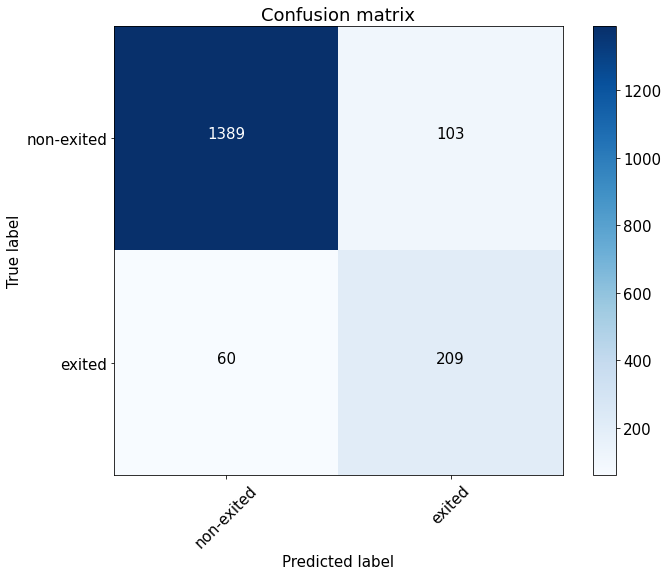

In [66]:
# Напишем функцию для построения матрицы ошибок

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, model_cb_best.predict(X_test))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['non-exited', 'exited'],
                      title='Confusion matrix')
plt.savefig('conf_matrix.png')
plt.show();

Из построенной матрицы ошибок можно сделать вывод:  
значение TrueNegative - 1389, т.е модель хорошо предсказывает пользователей, которые не уйдут.  
значение TruePositive - 209, т.е модель хорошо предсказывает пользователей, которые на самом деле не уйдут. Правильных ответов - 209 из 269.  
Значение False Positive - 60, т.е модель не так сильно промахивается в предсказании пользователей, которые уйдут. Неправильных ответов - 60 из 269.  
значение FalseNegative - 103, т.е модель иногда предсказывает, что пользователи, которые не должны уйти, уйдут. Это не так страшно, ведь главная цель, как можно лучше определить пользоватлей, которые могут покинуть сервис.   

В ходе тестирования лучшей модели мы проверили результаты модели CatBoostClassifier на тестовой выборке. По итогам анализа результатов было принято решение рекомендовать заказчику модель CatBoostClassifier с максимальным значением метрики AUC-ROC на тестовой выборке - 0.94  
Проверили нашу модель на адекватность, используя модель DummyClassifier. Метрика AUC-ROC модели DummyClassifier равна 0.5 Наша модель адекватна и эффективна.  
Построили матрицу ошибок и сделали вывод:  
значение TrueNegative - 1389, т.е модель хорошо предсказывает пользователей, которые не уйдут.  
значение TruePositive - 209, т.е модель хорошо предсказывает пользователей, которые на самом деле не уйдут. Правильных ответов - 209 из 269.  
Значение False Positive - 60, т.е модель не так сильно промахивается в предсказании пользователей, которые уйдут. Неправильных ответов - 60 из 269.  
значение FalseNegative - 103, т.е модель иногда предсказывает, что пользователи, которые не должны уйти, уйдут. Это не так страшно, ведь главная цель, как можно лучше определить пользоватлей, которые могут покинуть сервис. 

## Отчет

Основные этапы работы над проектом:  
  
    1. Загрузка и изучение данных

    2. Предобработка данных

    3. Исследовательский анализ данных

    4. Подготовка признаков для обучения моделей

    5. Обучение моделей

    6. Тестирование лучшей модели
    

Все этапы работы выполнены. Отличие от первоначального плана на этапе преодбработки данных: изменили целевой признак 'EndDate' и добавили столбец Exited - факт ухода клиента, также есть отличие на этапе подготовки признаков для обучения моделей - кодирование и масштабирование признаков выполняли вместе с обучением моделей, используя Pipeline.

Список признаков для обучения:  

BeginDate — дата начала пользования услугами  
CustomerId — уникальный идентификатор клиента  
Type — тип оплаты  
PaperlessBilling — безналичный расчет  
PaymentMethod — способ оплаты  
MonthlyCharges — ежемесячные траты на услуги  
TotalCharges — общие траты на услуги  
Dependents — наличие еждивенцев  
SeniorCitizen — наличие пенсионного статуса по возрасту  
Partner — наличие супруга(и)  
Gender — пол  
MultipleLines — возможность ведения параллельных линий во время звонка  

Целевой признак:  

Exited - факт ухода клиента  

На этапе предобработки данных в столбце 'end_date' заменим 'No' на дату выгрузки данных - 2020-02-01, т.е. клиент не расторгнул договор.  
Привели к типу datetime столбцы 'begin_date' и 'end_date'.  
Проверли пропущенные значения в столбце 'total_charges' и выяснили, что все незаполненные строки столбца 'total_charges' появились в одну дату - дату выгрузки датасета. Это новые клиенты и у них пока нет расходов за пользование услугами. Заполнили эти пропуски нулем и привели столбец 'total_charges' к численному типу. Привели столбец 'senior_citizen' к типу данных object, т.к. этот признак является категориальным.  
Объедили все таблицы в единый датасет по столбцу 'customer_i_d'. После объединения таблиц у нас появились пропуски в столбцах с дополнительными услугами интернета и телефонии. Заменили все пропуски на 'No'. В столбце 'InternetService' тип подключения к интернету самостоятельно заполнить пропуски мы не можем, поэтому заполнили их значением 'unknown'.
Привели все названия столбцов к нижнему регистру.  
Добавили столбец 'duration' - длительность обслуживания в днях. Добавили столбец 'exited' - факт ухода клиента, где 0 - действующий клиент, 1 - клиент расторгнул договор. Это будет наш целевой признак.  
Столбец 'customer_i_d' - идентификаторы клиента и не несёт ценности для обучения будущей модели, поэтому мы его удалили. Т.к. мы добавили столбец 'duration', то столбцы 'begin_date' и 'end_date' мы удалили, чтобы не было утечки данных.   

В ходе исследовательского анализа данных мы разделили признаки на количественные и категориальные.
Построили графики распределения количественных признаков в зависимости от столбца 'exited'. 
Построили графики распределения категориальных признаков в зависимости от столбца 'exited'.
Исследовали корреляцию признаков, применив инструмент фи-корреляции для смешанного набора признаков. Выявили, что столбцы 'internet_service', 'streaming_t_v', 'streaming_movies' сильно коррелируют с признаком 'monthly_charges'. Cтолбец 'total_charges' сильно коррелирует со столбцом 'duration'. Удалили столбцы 'internet_service', 'streaming_t_v', 'streaming_movies' и 'total_charges'.
Проверили целевой признак на дисбаланс классов. Выявили, что присутствует дисбаланс классов. Использовали балансировку классов внутри каждой модели. Применили метрику качества AUC-ROC, которая нечувствительна к дисбалансу.

На этапе подготовки признаков для дальнейшего обучения моделей мы разделили данные data на признаки и целевой признак и сохранили в отдельных переменных. Разобили данные на тренировочную и тестовую выборки. Размер тестовой выборки составил 0.25. Проверили размеры выборок. Подготовили категориальные признаки для OHE кодирования и количественные признаки для масштабирования. Кодирование и масштабирование признаков выполняли вместе с обучением, используя Pipeline.

Для обучения моделей мы применили следующие библиотеки: LogisticRegression, RandomForestClassifier, LightGBMClassifier и CatBoostClassifier. Для моделей мы подбирали оптимальные гиперпараметры с целью получения максимальной оценки метрики AUC-ROC. Для обучения моделей LogisticRegression, RandomForestClassifier, LightGBMClassifier мы применяли Pipeline, для модели CatBoostClassifier мы использовали библиотеку Optuna.  
Мы занесли результаты обучения моделей в таблицу и изучили их.  
  
  
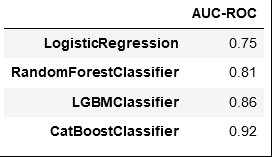
  

Лучшей моделью стала CatBoostClassifier (depth=3, iterations=571, learning_rate=0.31, cat_features = cat_features_test, auto_class_weights = 'Balanced', random_state=140823) с максимальным показалем AUC-ROC на тренировочной выборке 0.92

Проверили нашу модель на адекватность, используя модель DummyClassifier. Метрика AUC-ROC модели DummyClassifier равна 0.5. Наша модель адекватна и эффективна.

Построили график важности признаков. Определили, что признаки - 'duration', 'monthly_charges' и 'type' — являются самыми значимыми для обучения лучшей модели.

На всех этапах работы проблем не было. Также считаю все этапы в работе важными.